In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from pandas.core import datetools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics import utils
from scipy.stats import norm, skew 
from scipy.special import boxcox1p

import warnings

warnings.filterwarnings('ignore')
get_ipython().magic('matplotlib inline')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train_ID = train['Id']
test_ID = test['Id']

In [4]:
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [5]:
print("Train data : ", train.shape)
print("Test  data : ", test.shape)

Train data :  (1460, 80)
Test  data :  (1459, 79)


1.EDA

각 열에있는 데이터의 유형을 확인하는 작업을 하는 부분입니다.
설명에서 명확하게 설명해둔 부분이 아니라 추측하는 것이 직관적 않은 경우도 있습니다. 
아래의 두 항목이 그 예입니다.

Bedroom -> BedroomAbvGr  
Kitchen -> KitchenAbvGr  
등고선  -> Land Contour

In [6]:
test.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


우리의 목표가 SalePrice를 예측하는 것이므로, 어느 정도로 분배되는지 여부를 확인해야합니다.  
그렇지 않은 경우 변형이 필요합니다. 회귀 분석기는 정규 분포에서 가장 좋은 성능을 나타내기 때문입니다.  
Quantile-Quantile plot은 분포를 알려진 분포 (여기서는 "정규 분포")와 비교하는 좋은 방법입니다.  
quantile이 더 많이 일치할수록 두 분포가 더 유사합니다.  

In [7]:
def plot_dist_norm(dist, title):
    sns.distplot(dist, fit=norm);
    (mu, sigma) = norm.fit(dist);
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title(title)
    fig = plt.figure()
    res = stats.probplot(dist, plot=plt)
    plt.show()

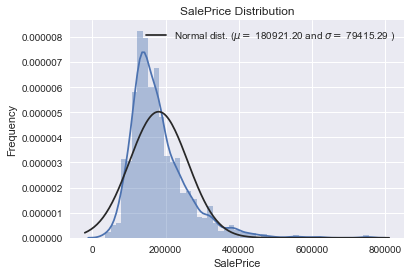

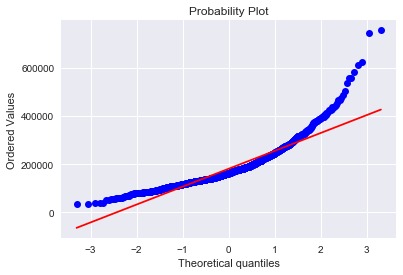

In [8]:
plot_dist_norm(train['SalePrice'], 'SalePrice Distribution')

딱! 보면 우리는 분포가 정상과는 거리가 먼 것을 알 수 있습니다. 
널리 사용되는 해결법은 로그 (1 + x) 변환을 이용하는 것입니다.  
Box Cox 변환을 시도했지만, 그렇게하면 분석이 엉망이되었습니다 아마 많은 피처의 의존성이 억제되도록 분포를 너무 왜곡시켜서   
그런 결과를 보이게 된것이라 생각됩니다.

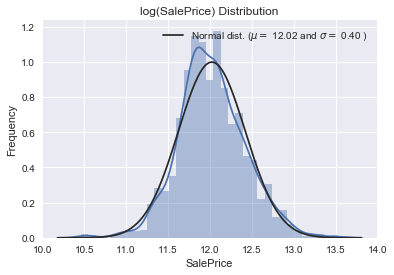

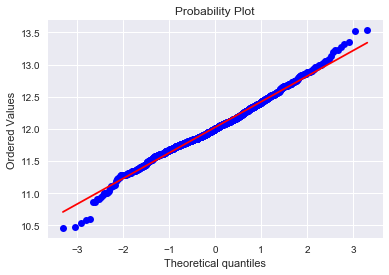

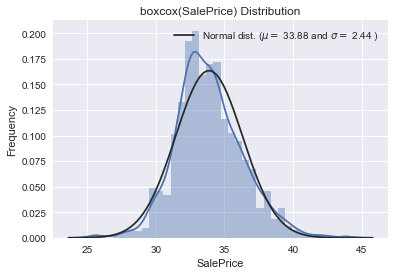

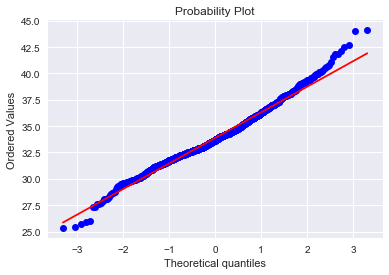

In [9]:
transform_log = np.log1p(train["SalePrice"])
transform_boxcox = boxcox1p(train["SalePrice"], 0.15)

plot_dist_norm(transform_log, 'log(SalePrice) Distribution')
plot_dist_norm(transform_boxcox, 'boxcox(SalePrice) Distribution')

In [10]:
train["SalePrice"] = transform_log

 SalePrice와 GrLivArea 사이의 선형 관계를 가정한다면 몇몇 특이 치가 있습니다.

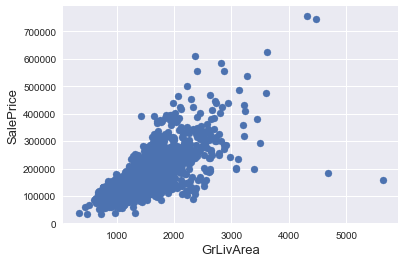

In [11]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = np.expm1(train['SalePrice']))
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

선형 관계를 가정하고 그것을 이상치로 취급하는 것은 잠시 가정하는것이고  
이 두 점에는 의미있는 정보가 포함되어있을 수 있지만 회귀자를 도울 가능성이 더 큽니다. 회귀 분석기는 선형성을 "강제"함으로써 더 잘 작동하므로 더 좋은 결과를 제공합니다. 사실, 이러한 이상 치를 제외하면 모든 모델에 대한 분석에서 std ()가 절반으로 줄어 들었습니다.  
따라서 이 두 수치는 제외하도록 하겠습니다

In [12]:
train = train.drop(train[(train['GrLivArea']>4000) & (np.expm1(train['SalePrice'])<300000)].index)

기존의 train, test set 데이터를 합치면 데이터셋들을 동시에 컨트롤 할 수 있음과 동시에 편리하고  
실수할 가능서을 많이 줄여주기에 이런 방법으로 진행하겠습니다

In [13]:
all_data = pd.concat((train, test)).reset_index(drop=True)

많은 결정은 매우 주관적이고 모호하지만, 훈련 된 모델의 예측 가능성에 영향을 많이 주기때문에 중요합니다.  
이렇게하기 위해 어떤 기능에 데이터가 누락되었는지 확인합니다.

In [14]:
cp_a_data = all_data.copy()
cp_a_data.drop(['SalePrice'], axis=1, inplace=True)
all_data_null = cp_a_data.isnull().sum()
all_data_null = all_data_null.drop(all_data_null[all_data_null == 0].index).sort_values(ascending=False)
all_data_missing = pd.DataFrame({'Missing Numbers' :all_data_null})
all_data_missing

Missing Numbers
PoolQC                   2908
MiscFeature              2812
Alley                    2719
Fence                    2346
FireplaceQu              1420
LotFrontage               486
GarageQual                159
GarageCond                159
GarageFinish              159
GarageYrBlt               159
GarageType                157
BsmtExposure               82
BsmtCond                   82
BsmtQual                   81
BsmtFinType2               80
BsmtFinType1               79
MasVnrType                 24
MasVnrArea                 23
MSZoning                    4
BsmtFullBath                2
BsmtHalfBath                2
Utilities                   2
Functional                  2
Electrical                  1
BsmtUnfSF                   1
Exterior1st                 1
Exterior2nd                 1
TotalBsmtSF                 1
GarageArea                  1
GarageCars                  1
BsmtFinSF2                  1
BsmtFinSF1                  1
KitchenQual                 1
SaleType                    1

Text(0.5,1,'Percent missing data by feature')

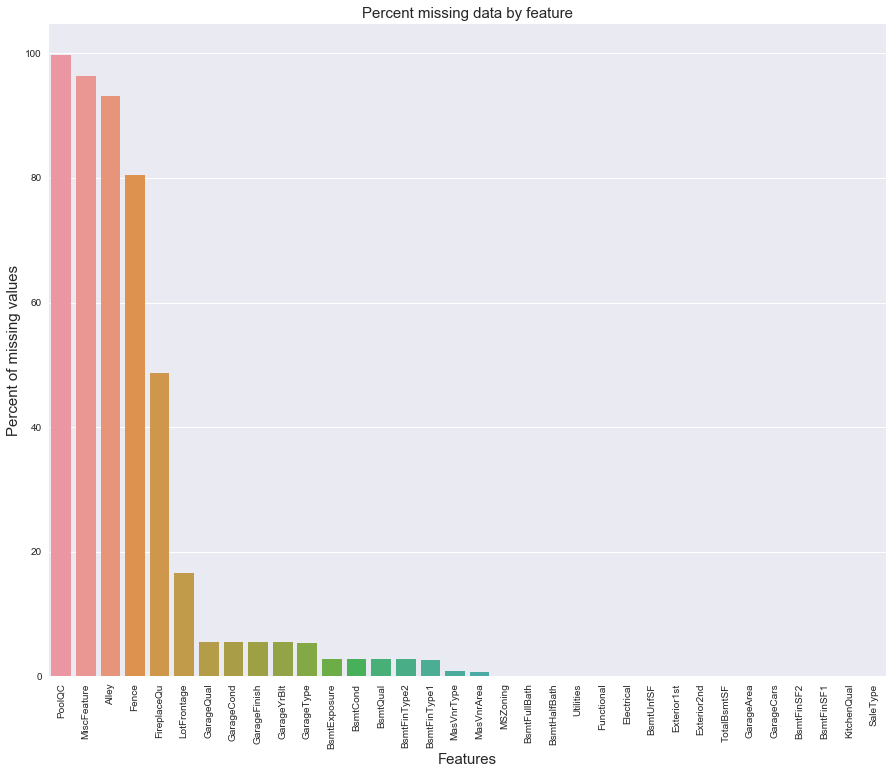

In [15]:
all_data_null =  all_data_null / len(cp_a_data)*100
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_null.index, y=all_data_null)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

자 그럼 이것을 토대로 하나하나씩 비어있는 데이터가 적은 것부터 채워나가보도록 하겠습니다

In [16]:
all_data['SaleType'].value_counts()

WD       2525
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

데이터를 보고 떠오르는게 딱히 없어서 일단은.. 가장 많이 보이는 값을 채워넣도록 하겠습니다

In [17]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['SaleType'].value_counts()

WD       2526
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [18]:
all_data['KitchenQual'].value_counts()

TA    1492
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

우리에게 익숙치 않은 TA 라는 라벨이 있는데 여기서는 표준/평균 정도로 생각하시면 됩니다.
이곳 또한 mode로 데이터를 채워넣도록 하겠습니다

In [19]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['KitchenQual'].value_counts()

TA    1493
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

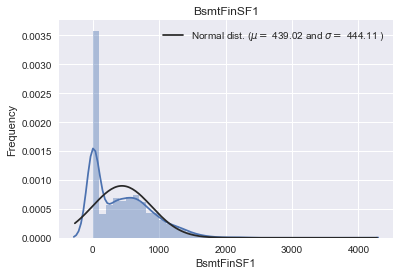

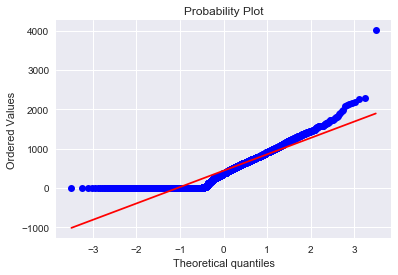

In [20]:
plot_dist_norm(all_data['BsmtFinSF1'].dropna(), 'BsmtFinSF1')

Nan값은 0으로 채워줍니다.

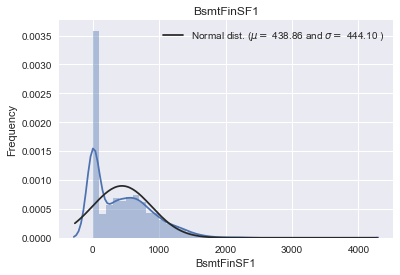

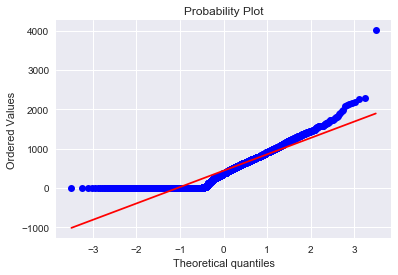

In [21]:
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].fillna(0)
plot_dist_norm(all_data['BsmtFinSF1'], 'BsmtFinSF1')

BsmtFinSF2 도 위의 데이터와 같으니 동일한 작업을 진행해 줍니다

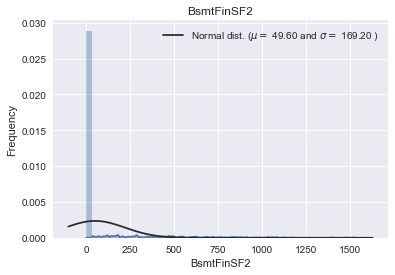

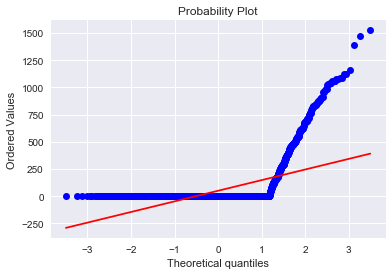

In [22]:
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].fillna(0)
plot_dist_norm(all_data['BsmtFinSF2'], 'BsmtFinSF2')

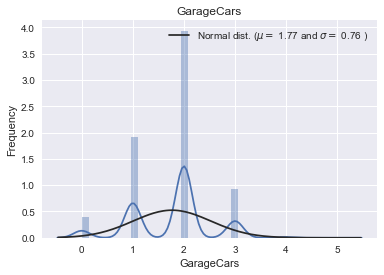

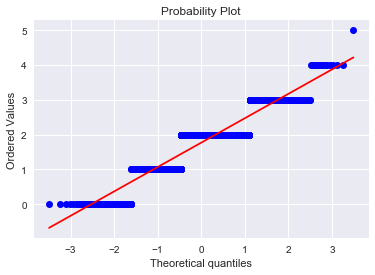

In [23]:
plot_dist_norm(all_data['GarageCars'].dropna(), 'GarageCars')

GarageCars 도 동일하게 작업해줍니다.

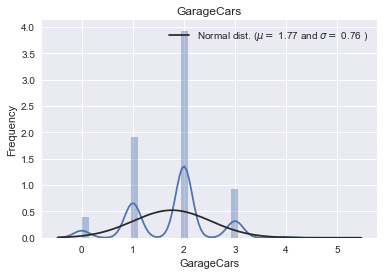

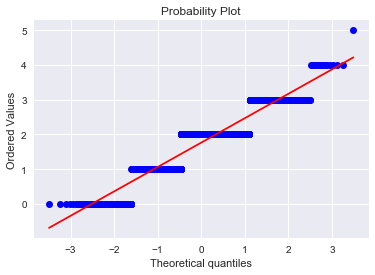

In [24]:
all_data['GarageCars'] = all_data['GarageCars'].fillna(0)
plot_dist_norm(all_data['GarageCars'], 'GarageCars')

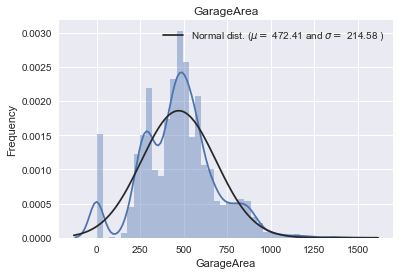

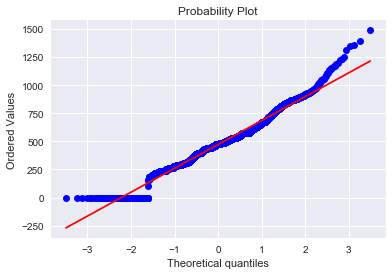

In [25]:
plot_dist_norm(all_data['GarageArea'].dropna(), 'GarageArea')

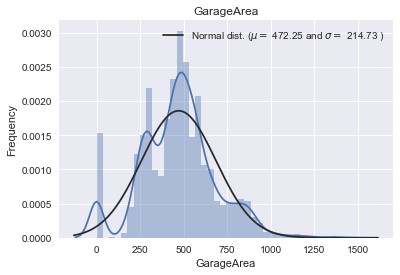

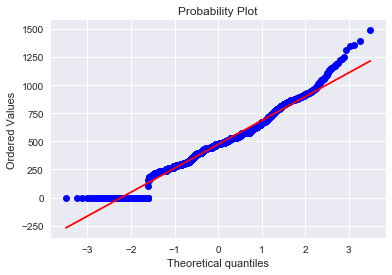

In [26]:
all_data['GarageArea'] = all_data['GarageArea'].fillna(0)
plot_dist_norm(all_data['GarageArea'], 'GarageArea')

In [27]:
all_data['TotalBsmtSF'].value_counts()

0.0       78
864.0     74
672.0     29
912.0     26
1040.0    25
768.0     24
816.0     23
728.0     20
780.0     19
384.0     19
1008.0    19
960.0     18
756.0     17
832.0     17
894.0     17
546.0     16
848.0     16
720.0     16
600.0     16
936.0     16
483.0     14
630.0     13
952.0     13
840.0     13
988.0     12
624.0     12
796.0     11
784.0     11
876.0     11
1056.0    10
          ..
1967.0     1
1905.0     1
1679.0     1
1533.0     1
2140.0     1
1994.0     1
1378.0     1
763.0      1
1047.0     1
1376.0     1
904.0      1
370.0      1
1570.0     1
2033.0     1
1709.0     1
1519.0     1
2077.0     1
1550.0     1
797.0      1
699.0      1
559.0      1
396.0      1
1866.0     1
1641.0     1
961.0      1
1949.0     1
1231.0     1
1829.0     1
1475.0     1
1243.0     1
Name: TotalBsmtSF, Length: 1056, dtype: int64

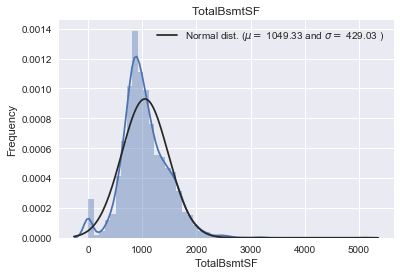

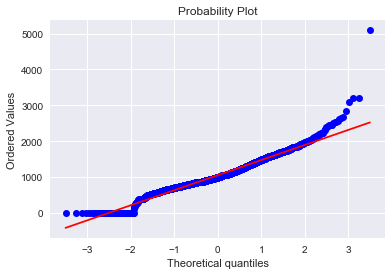

In [28]:
plot_dist_norm(all_data['TotalBsmtSF'].dropna(), 'TotalBsmtSF')

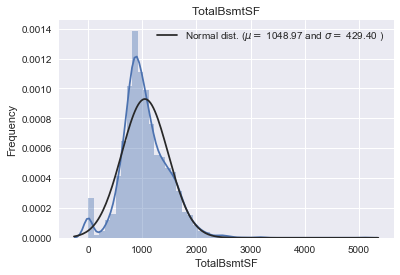

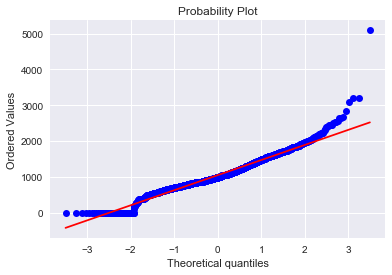

In [29]:
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
plot_dist_norm(all_data['TotalBsmtSF'], 'TotalBsmtSF')

In [30]:
all_data['Exterior2nd'].value_counts()

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

In [31]:
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['Exterior2nd'].value_counts()

VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

In [32]:
all_data['Exterior1st'].value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
CBlock        2
Stone         2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64

In [33]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior1st'].value_counts()

VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
CBlock        2
Stone         2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64

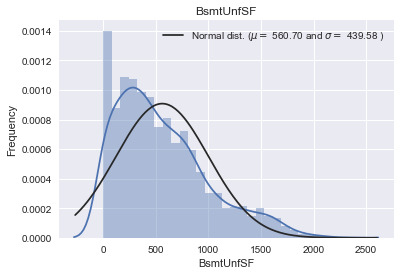

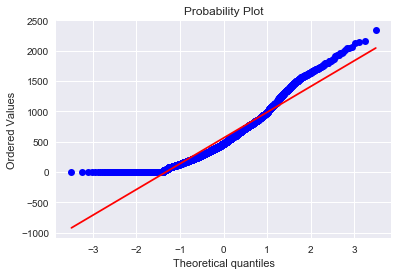

In [34]:
plot_dist_norm(all_data['BsmtUnfSF'].dropna(), 'BsmtUnfSF')

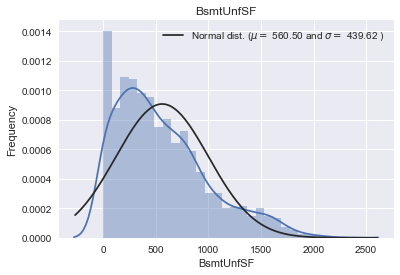

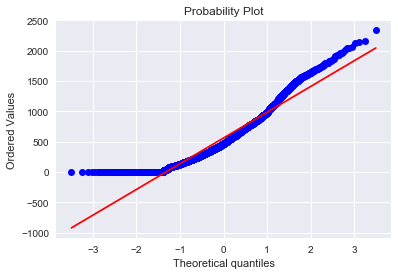

In [35]:
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].fillna(0)
plot_dist_norm(all_data['BsmtUnfSF'], 'BsmtUnfSF')

In [36]:
all_data['Electrical'].value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

?????

In [37]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['Electrical'].value_counts()

SBrkr    2670
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [38]:
all_data['Functional'].value_counts()

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

특이한 데이터 

In [39]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [40]:
test['Utilities'].value_counts()

AllPub    1457
Name: Utilities, dtype: int64

테스트 데이터를 보면 모두 AllPub으로 되어있다 지우도록한다.

In [41]:
all_data.drop(['Utilities'], axis=1, inplace=True)

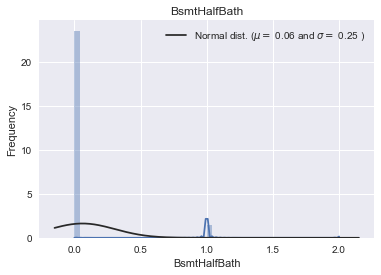

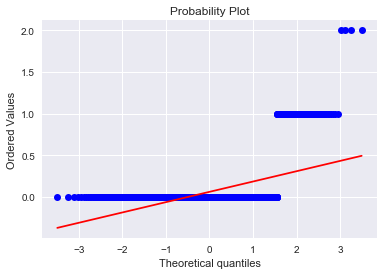

In [42]:
plot_dist_norm(all_data['BsmtHalfBath'].dropna(), 'BsmtHalfBath')

NaN은 full / half 욕실이 없음을 의미합니다.

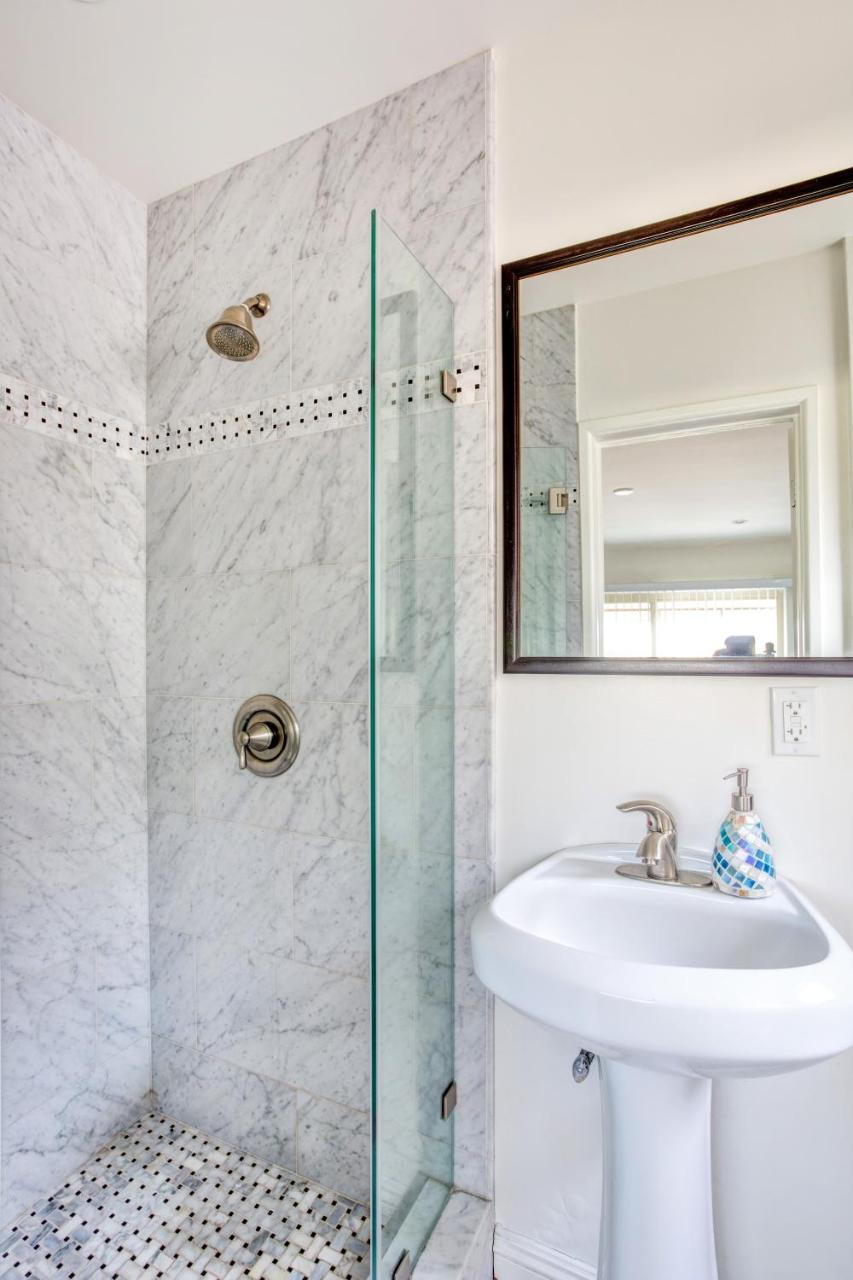

  
  
  
full bath - 욕조나 샤워시설이 있는곳을 의미

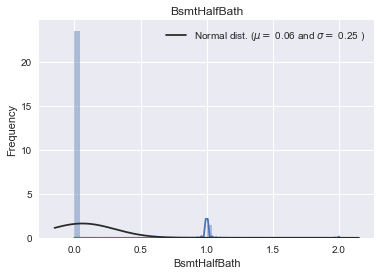

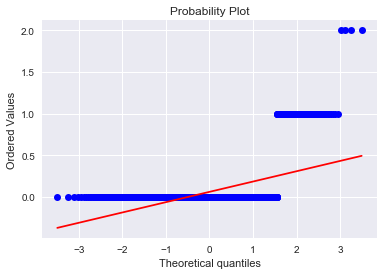

In [43]:
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0)
plot_dist_norm(all_data['BsmtHalfBath'], 'BsmtHalfBath')

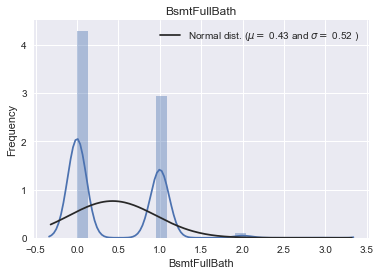

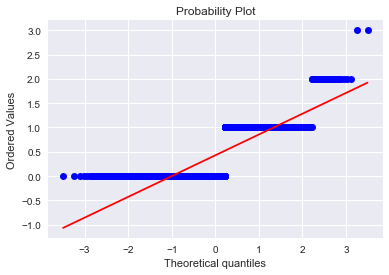

In [44]:
plot_dist_norm(all_data['BsmtFullBath'].dropna(), 'BsmtFullBath')

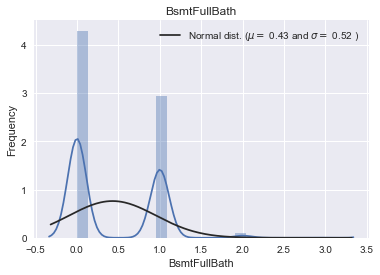

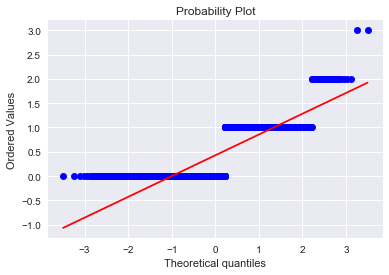

In [45]:
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0)
plot_dist_norm(all_data['BsmtFullBath'], 'BsmtFullBath')

In [46]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

알수없는 라벨들이다.. 이럴땐? 평균적인 값을 넣어보자

In [47]:
all_data['MSZoning']=all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['MSZoning'].value_counts()

RL         2267
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

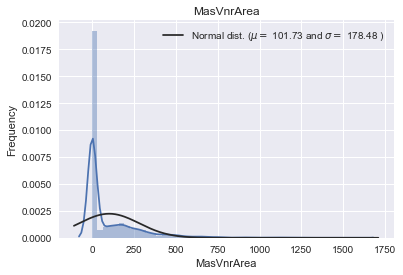

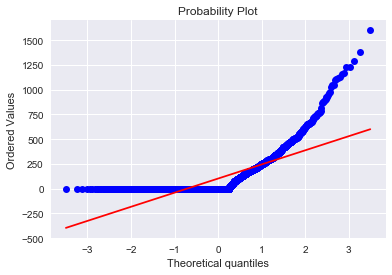

In [48]:
plot_dist_norm(all_data['MasVnrArea'].dropna(), 'MasVnrArea')

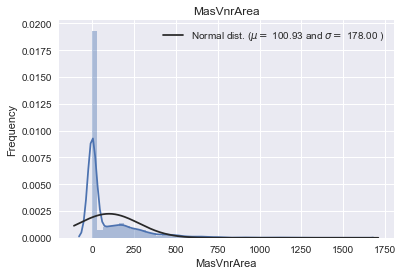

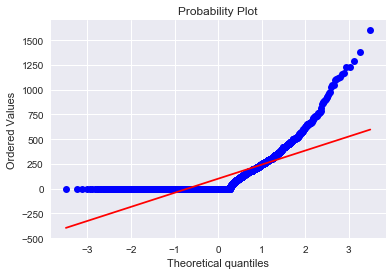

In [49]:
all_data['MasVnrArea']=all_data['MasVnrArea'].fillna(0)
plot_dist_norm(all_data['MasVnrArea'], 'MasVnrArea')

In [50]:
all_data['MasVnrType'].value_counts()

None       1742
BrkFace     879
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

Nan값은 대부분 None 값으로 볼 수 있다.

In [51]:
all_data['MasVnrType']=all_data['MasVnrType'].fillna('None')
all_data['MasVnrType'].value_counts()

None       1766
BrkFace     879
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

In [52]:
all_data['BsmtFinType1'].value_counts()

Unf    851
GLQ    847
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64

어느 한쪽에 넣기엔 데이터가 치우쳐질 가능성이 있으니 넘어간다!

In [53]:
all_data['BsmtFinType2'].value_counts()

Unf    2491
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

여기에선 Unf에 Nan값을 넣을 수 있을지도 모르겠지만 
위의 데이터와 통일하기위해 이 데이터도 다른 행동은 하지않는다.

In [54]:
all_data['BsmtFinType2']=all_data['BsmtFinType2'].fillna('None')
all_data['BsmtFinType2'].value_counts()

Unf     2491
Rec      105
LwQ       87
None      80
BLQ       68
ALQ       52
GLQ       34
Name: BsmtFinType2, dtype: int64

In [55]:
all_data['BsmtQual'].value_counts()

TA    1283
Gd    1209
Ex     256
Fa      88
Name: BsmtQual, dtype: int64

지하실의 품질? 이라곤 하지만 이 데이터에선 아마도 Nan값은 mean값이라기보단 지하실이 없어서 품질측정을 못했을 것으로 예측해서  
None값을 사용합니다

In [56]:
all_data['BsmtQual']=all_data['BsmtQual'].fillna('None')
all_data['BsmtQual'].value_counts()

TA      1283
Gd      1209
Ex       256
Fa        88
None      81
Name: BsmtQual, dtype: int64

In [57]:
all_data['BsmtCond'].value_counts()

TA    2604
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64

여기서 말하는 condition 분명 위에서 말하는 BsmtQual과는 다를것이지만..  
정확하게 추측할 수 있는 정보가 없기때문에 이것또한 None값으로 채워주도록 합니다

In [58]:
all_data['BsmtCond']=all_data['BsmtCond'].fillna('None')
all_data['BsmtCond'].value_counts()

TA      2604
Gd       122
Fa       104
None      82
Po         5
Name: BsmtCond, dtype: int64

In [59]:
all_data['BsmtExposure'].value_counts()

No    1904
Av     418
Gd     274
Mn     239
Name: BsmtExposure, dtype: int64

여기에서 말하는 No는 아예 없다는 의미이지만  
여기선 지하실이 없는 사람들도 포함될것으로 예상됩니다.

In [60]:
all_data['BsmtExposure']=all_data['BsmtExposure'].fillna('None')
all_data['BsmtExposure'].value_counts()

No      1904
Av       418
Gd       274
Mn       239
None      82
Name: BsmtExposure, dtype: int64

In [61]:
all_data['GarageType'].value_counts()

Attchd     1722
Detchd      779
BuiltIn     185
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64

여기서 Nan값은 차고가 없는것을 의미합니다.

In [62]:
all_data['GarageType']=all_data['GarageType'].fillna('None')
all_data['GarageType'].value_counts()

Attchd     1722
Detchd      779
BuiltIn     185
None        157
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64

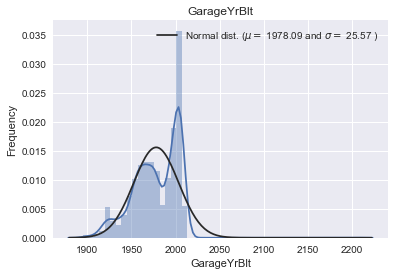

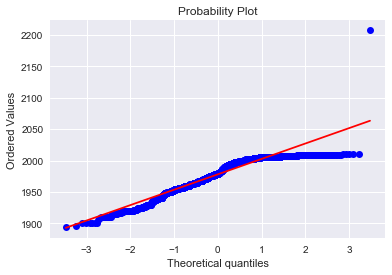

In [63]:
plot_dist_norm(all_data['GarageYrBlt'].dropna(), 'GarageYrBlt')

준공 예정인 집이 벌써 데이터에 들어가있는건가?!
지워줍니다!!

In [64]:
all_data['GarageYrBlt'][all_data['GarageYrBlt']>2150]

2590    2207.0
Name: GarageYrBlt, dtype: float64

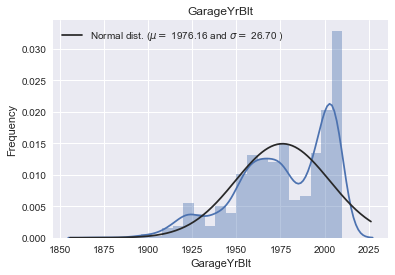

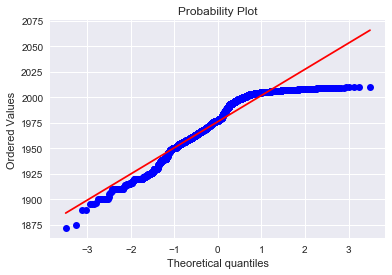

In [65]:
all_data['GarageYrBlt']=all_data['GarageYrBlt'].fillna(all_data['YearBuilt'][ all_data['GarageYrBlt'].isnull()])
all_data['GarageYrBlt'][all_data['GarageYrBlt']>2018] = all_data['YearBuilt'][all_data['GarageYrBlt']>2018]
plot_dist_norm(all_data['GarageYrBlt'], 'GarageYrBlt')

garage에 nan값을 넣게되면 0으로 변환된 상태에서 다른값이 들어갈 수도 있기에  
정리해준다.

In [66]:
all_data['GarageFinish'].value_counts()

Unf    1230
RFn     811
Fin     717
Name: GarageFinish, dtype: int64

In [67]:
all_data['GarageFinish']=all_data['GarageFinish'].fillna('None')
all_data['GarageFinish'].value_counts()

Unf     1230
RFn      811
Fin      717
None     159
Name: GarageFinish, dtype: int64

In [68]:
all_data['GarageCond'].value_counts()

TA    2652
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64

In [69]:
all_data['GarageCond']=all_data['GarageCond'].fillna('None')
all_data['GarageCond'].value_counts()

TA      2652
None     159
Fa        74
Gd        15
Po        14
Ex         3
Name: GarageCond, dtype: int64

In [70]:
all_data['GarageQual'].value_counts()

TA    2602
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64

In [71]:
all_data['GarageQual']=all_data['GarageQual'].fillna('None')
all_data['GarageQual'].value_counts()

TA      2602
None     159
Fa       124
Gd        24
Po         5
Ex         3
Name: GarageQual, dtype: int64

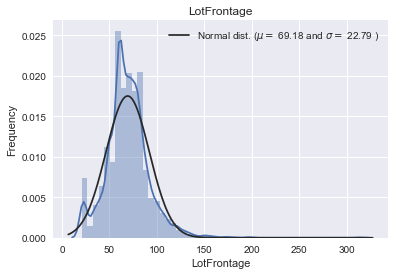

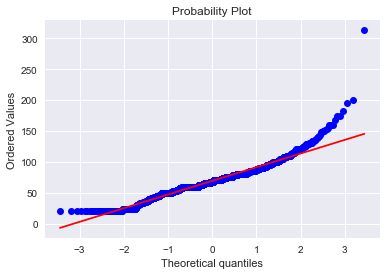

In [72]:
plot_dist_norm(all_data['LotFrontage'].dropna(), 'LotFrontage')

이웃에 따라 추측해보는것이 좋을것같다. -커널 내에서 인사이트얻음
median값으로 넣어줍니다.

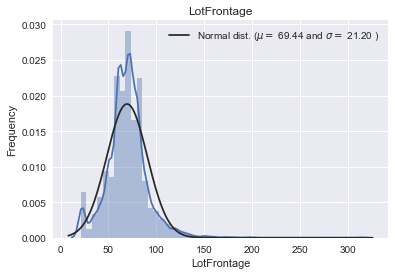

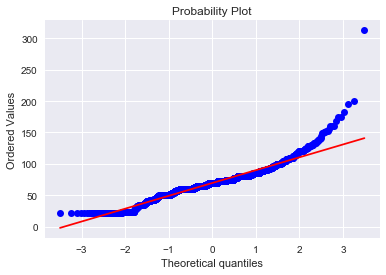

In [73]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
plot_dist_norm(all_data['LotFrontage'], 'LotFrontage')

In [74]:
all_data['FireplaceQu'].value_counts()

Gd    742
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64

In [75]:
all_data['FireplaceQu']=all_data['FireplaceQu'].fillna('None')
all_data['FireplaceQu'].value_counts()

None    1420
Gd       742
TA       592
Fa        74
Po        46
Ex        43
Name: FireplaceQu, dtype: int64

In [76]:
all_data['Fence'].value_counts()

MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

In [77]:
all_data['Fence']=all_data['Fence'].fillna('None')
all_data['Fence'].value_counts()

None     2346
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64

In [78]:
all_data['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [79]:
all_data['Alley']=all_data['Alley'].fillna('None')
all_data['Alley'].value_counts()

None    2719
Grvl     120
Pave      78
Name: Alley, dtype: int64

??? 무슨데이터인지 모르겠어서 일단 None 넣어둠

In [80]:
all_data['MiscFeature'].value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [81]:
all_data['MiscFeature']=all_data['MiscFeature'].fillna('None')
all_data['MiscFeature'].value_counts()

None    2812
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64

In [82]:
all_data['PoolQC'].value_counts()

Ex    4
Gd    3
Fa    2
Name: PoolQC, dtype: int64

In [83]:
all_data['PoolQC']=all_data['PoolQC'].fillna('None')
all_data['PoolQC'].value_counts()

None    2908
Ex         4
Gd         3
Fa         2
Name: PoolQC, dtype: int64

category 대신 숫자로 문자열의 일부를 대신 해야하는 데이터들

In [84]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].astype(str)
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)
all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
all_data['GarageCars'] = all_data['GarageCars'].astype(str)

조금 더 좋은 선형성을 위해 기존 데이터를 수정,  
새로운 데이터를 만듭니다.

In [85]:
all_data['TotalSF']=all_data['TotalBsmtSF']+all_data['1stFlrSF']+all_data['2ndFlrSF']

In [86]:
from sklearn.preprocessing import LabelEncoder

In [87]:
feats = ('ExterCond','HeatingQC', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold','GarageYrBlt','YearBuilt','YearRemodAdd', 'BsmtHalfBath','BsmtFullBath', 'GarageCars')
    
# label encode

for feat in feats:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[feat].values)) 
    all_data[feat] = lbl.transform(list(all_data[feat].values))

레이블별 기준에 따라 인코드 해야함. 
일부 카테고리  ExterCond, HeatingQC 및 BsmtExposure 와 같은 애들은 category시 더 안좋은 결과를 보이기에 이런 데이터들은 제외했습니다.
또 Fence..LandSlope,LotShape,PavedDrive feature또한 인코딩 하지 않아야 좀 더 괜찮은 결과를 얻을 수 있어서 이렇게 처리했습니다.

In [88]:
all_data.FireplaceQu = all_data.FireplaceQu.astype('category', ordered=True, categories=['None','Po','Fa','TA','Gd','Ex']).cat.codes
all_data.BsmtQual = all_data.BsmtQual.astype('category', ordered=True, categories=['None','Fa','TA','Gd','Ex']).cat.codes
all_data.BsmtCond = all_data.BsmtCond.astype('category', ordered=True, categories=['None','Po','Fa','TA','Gd']).cat.codes
all_data.GarageQual = all_data.GarageQual.astype('category', ordered=True, categories=['None','Po','Fa','TA','Gd','Ex']).cat.codes
all_data.GarageCond = all_data.GarageCond.astype('category', ordered=True, categories=['None','Po','Fa','TA','Gd','Ex']).cat.codes
all_data.ExterQual = all_data.ExterQual.astype('category', ordered=True, categories=['Fa','TA','Gd','Ex']).cat.codes
all_data.PoolQC = all_data.PoolQC.astype('category', ordered=True, categories=['None','Fa','Gd','Ex']).cat.codes
all_data.KitchenQual = all_data.KitchenQual.astype('category', ordered=True, categories=['Fa','TA','Gd','Ex']).cat.codes

많은 feature들이 정규분포를 따르지 않는것을 확인,  
이상점을 확인하고 이에따른 조치를 취해줘야합니다.

Text(0.5,1,'Skewness by feature')

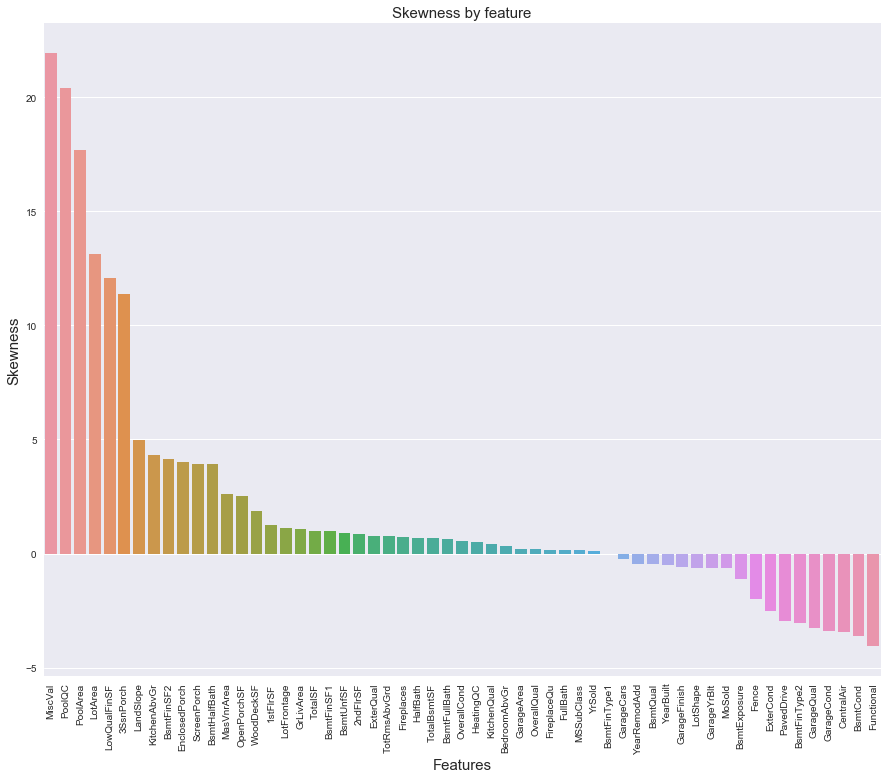

In [89]:
skewed_feats = all_data[all_data.dtypes[all_data.dtypes != "object"].index].apply(lambda x: skew(x.dropna())).drop('SalePrice').sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats.index, y=skewed_feats)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('Skewness by feature', fontsize=15)

boxcox 변환이 더 좋은 결과를 얻어냈다.

In [90]:
for feat in skewness[abs(skewness)>0.5].index:
    all_data[feat] = boxcox1p(all_data[feat], 0.15)

더미화

In [91]:
# all_data = pd.get_dummies(all_data)

데이터가 정리되었기에 드이더 SalePrice와 상관관계를 확인할 수 있습니다!
다시 전체 데이터 세트를 다시 분할합니다.

In [92]:
new_train = all_data[all_data['SalePrice'].notnull()]
new_test=all_data[all_data['SalePrice'].isnull()]
new_test.drop('SalePrice', axis=1, inplace=True)

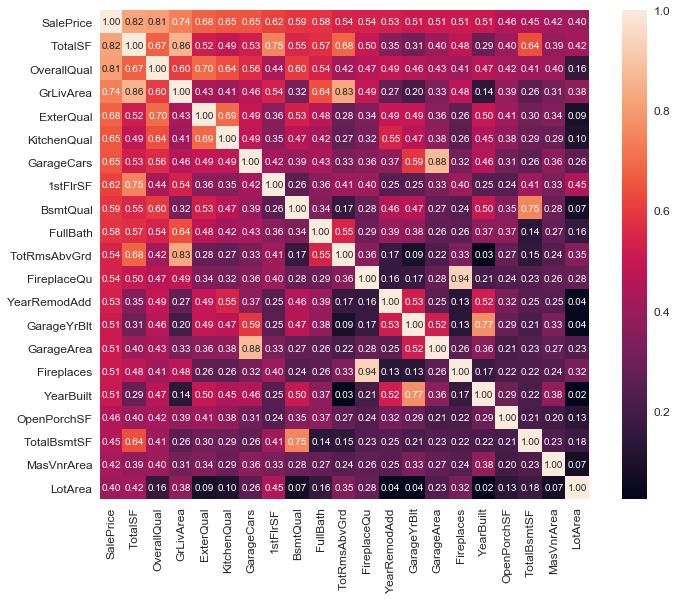

In [93]:
corrmat = new_train.corr()
features = corrmat.nlargest(52, 'SalePrice')['SalePrice'].index
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,9))
relevant_features = features[:21]
sns.heatmap(new_train[relevant_features].corr(), cbar=True, annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=relevant_features.values, xticklabels=relevant_features.values, vmax=1, square=True)

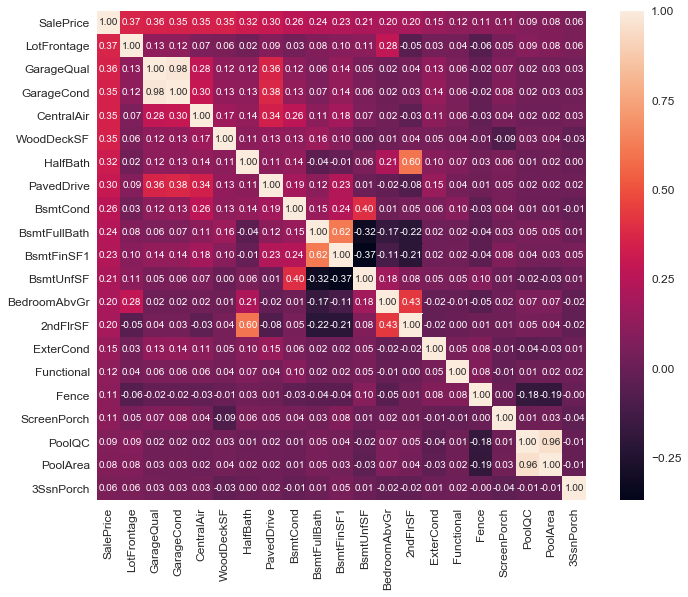

In [94]:
relevant_features = ['SalePrice']
relevant_features = np.append(relevant_features,features[21:41])
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,9))
sns.heatmap(new_train[relevant_features].corr(), cbar=True, annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=relevant_features, xticklabels=relevant_features, vmax=1, square=True)

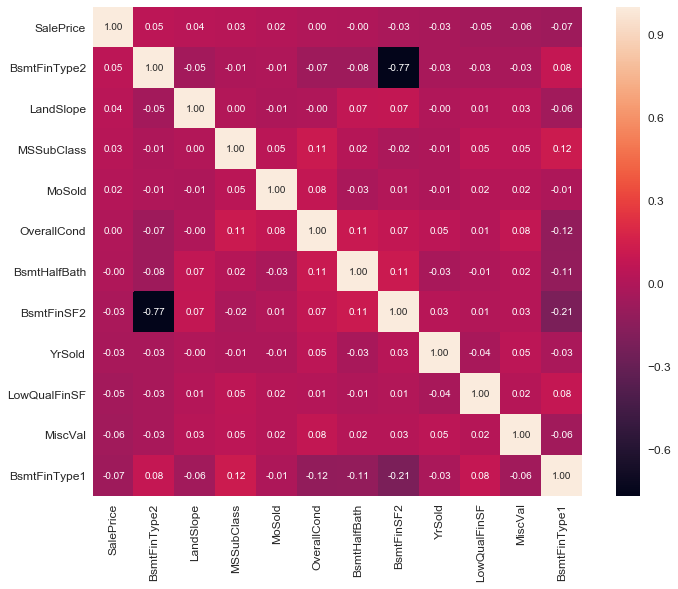

In [95]:
relevant_features = ['SalePrice']
relevant_features = np.append(relevant_features,features[41:])
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,9))
sns.heatmap(new_train[relevant_features].corr(), cbar=True, annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=relevant_features, xticklabels=relevant_features, vmax=1, square=True)

위의 상관관계를 살펴보았을때 예상되는 상호 연관관계도 있고, 그렇지 않은 데이터들의 상관관계도 볼 수 있다.
그렇지 않은 경우에는.. 대체하는 다른 방법을 찾는수 밖에 없을것같다.

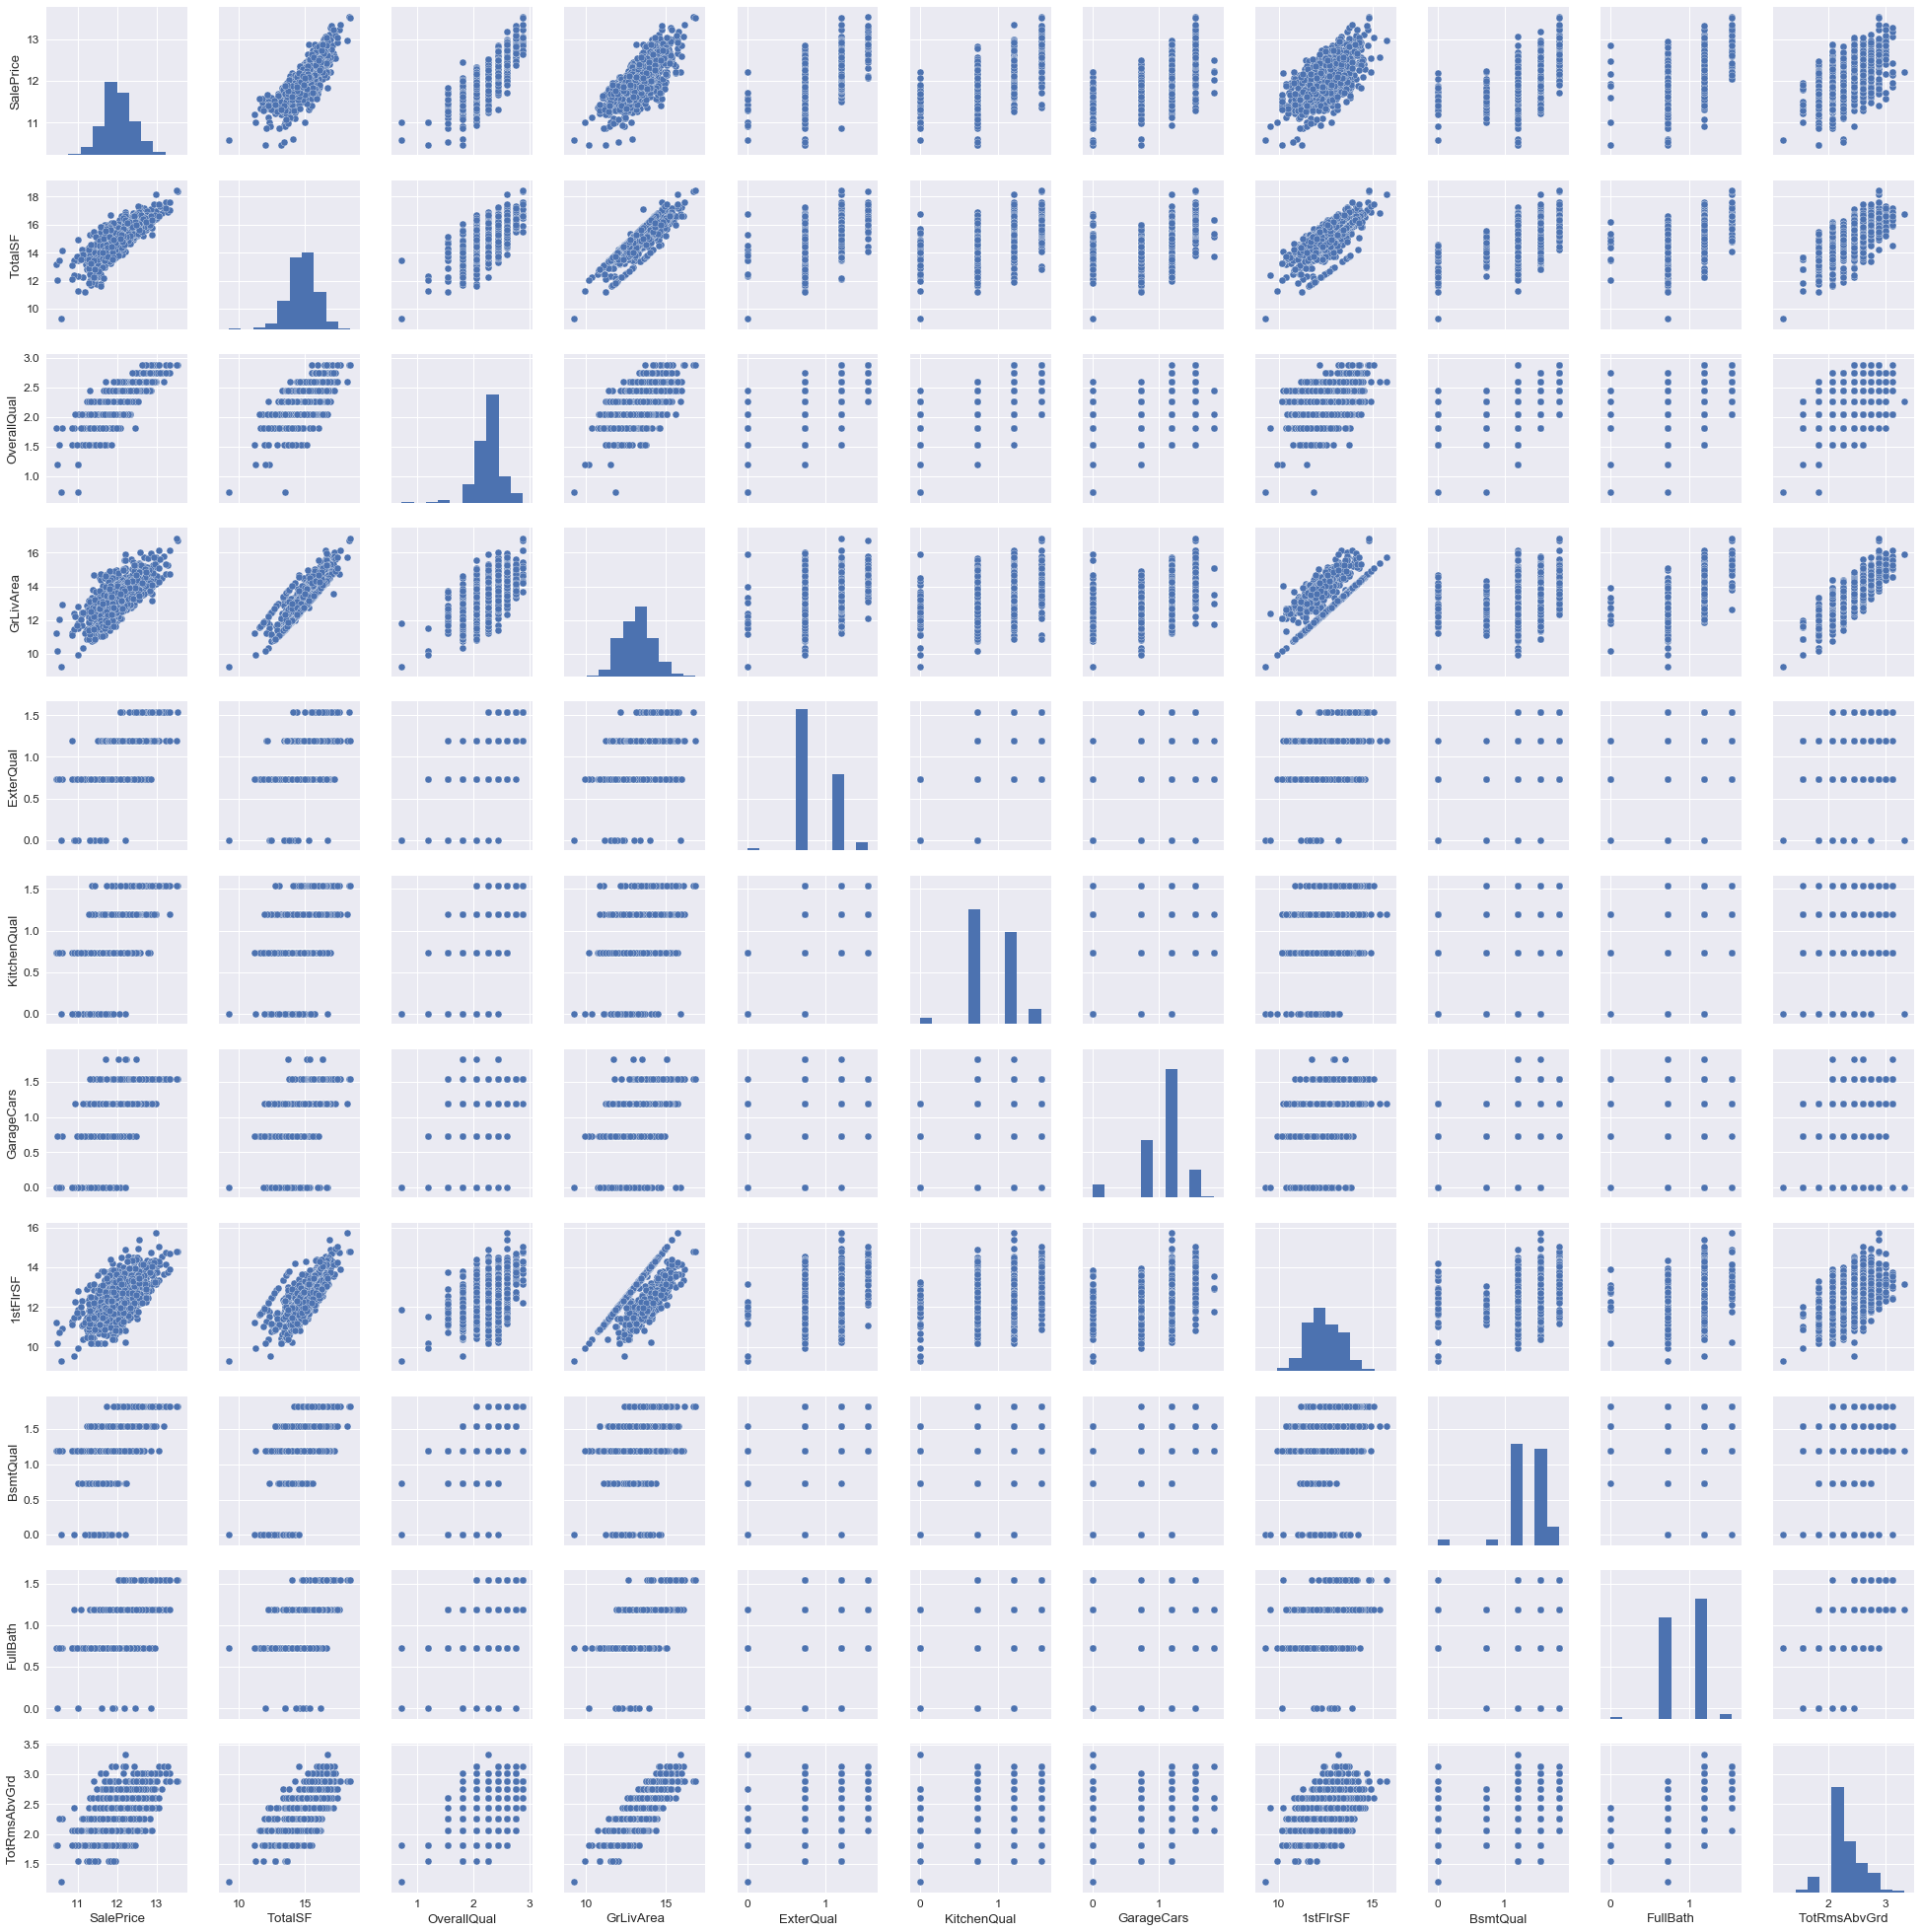

In [96]:
pairing = features[:11]
sns.pairplot(new_train[pairing], size=2.5)

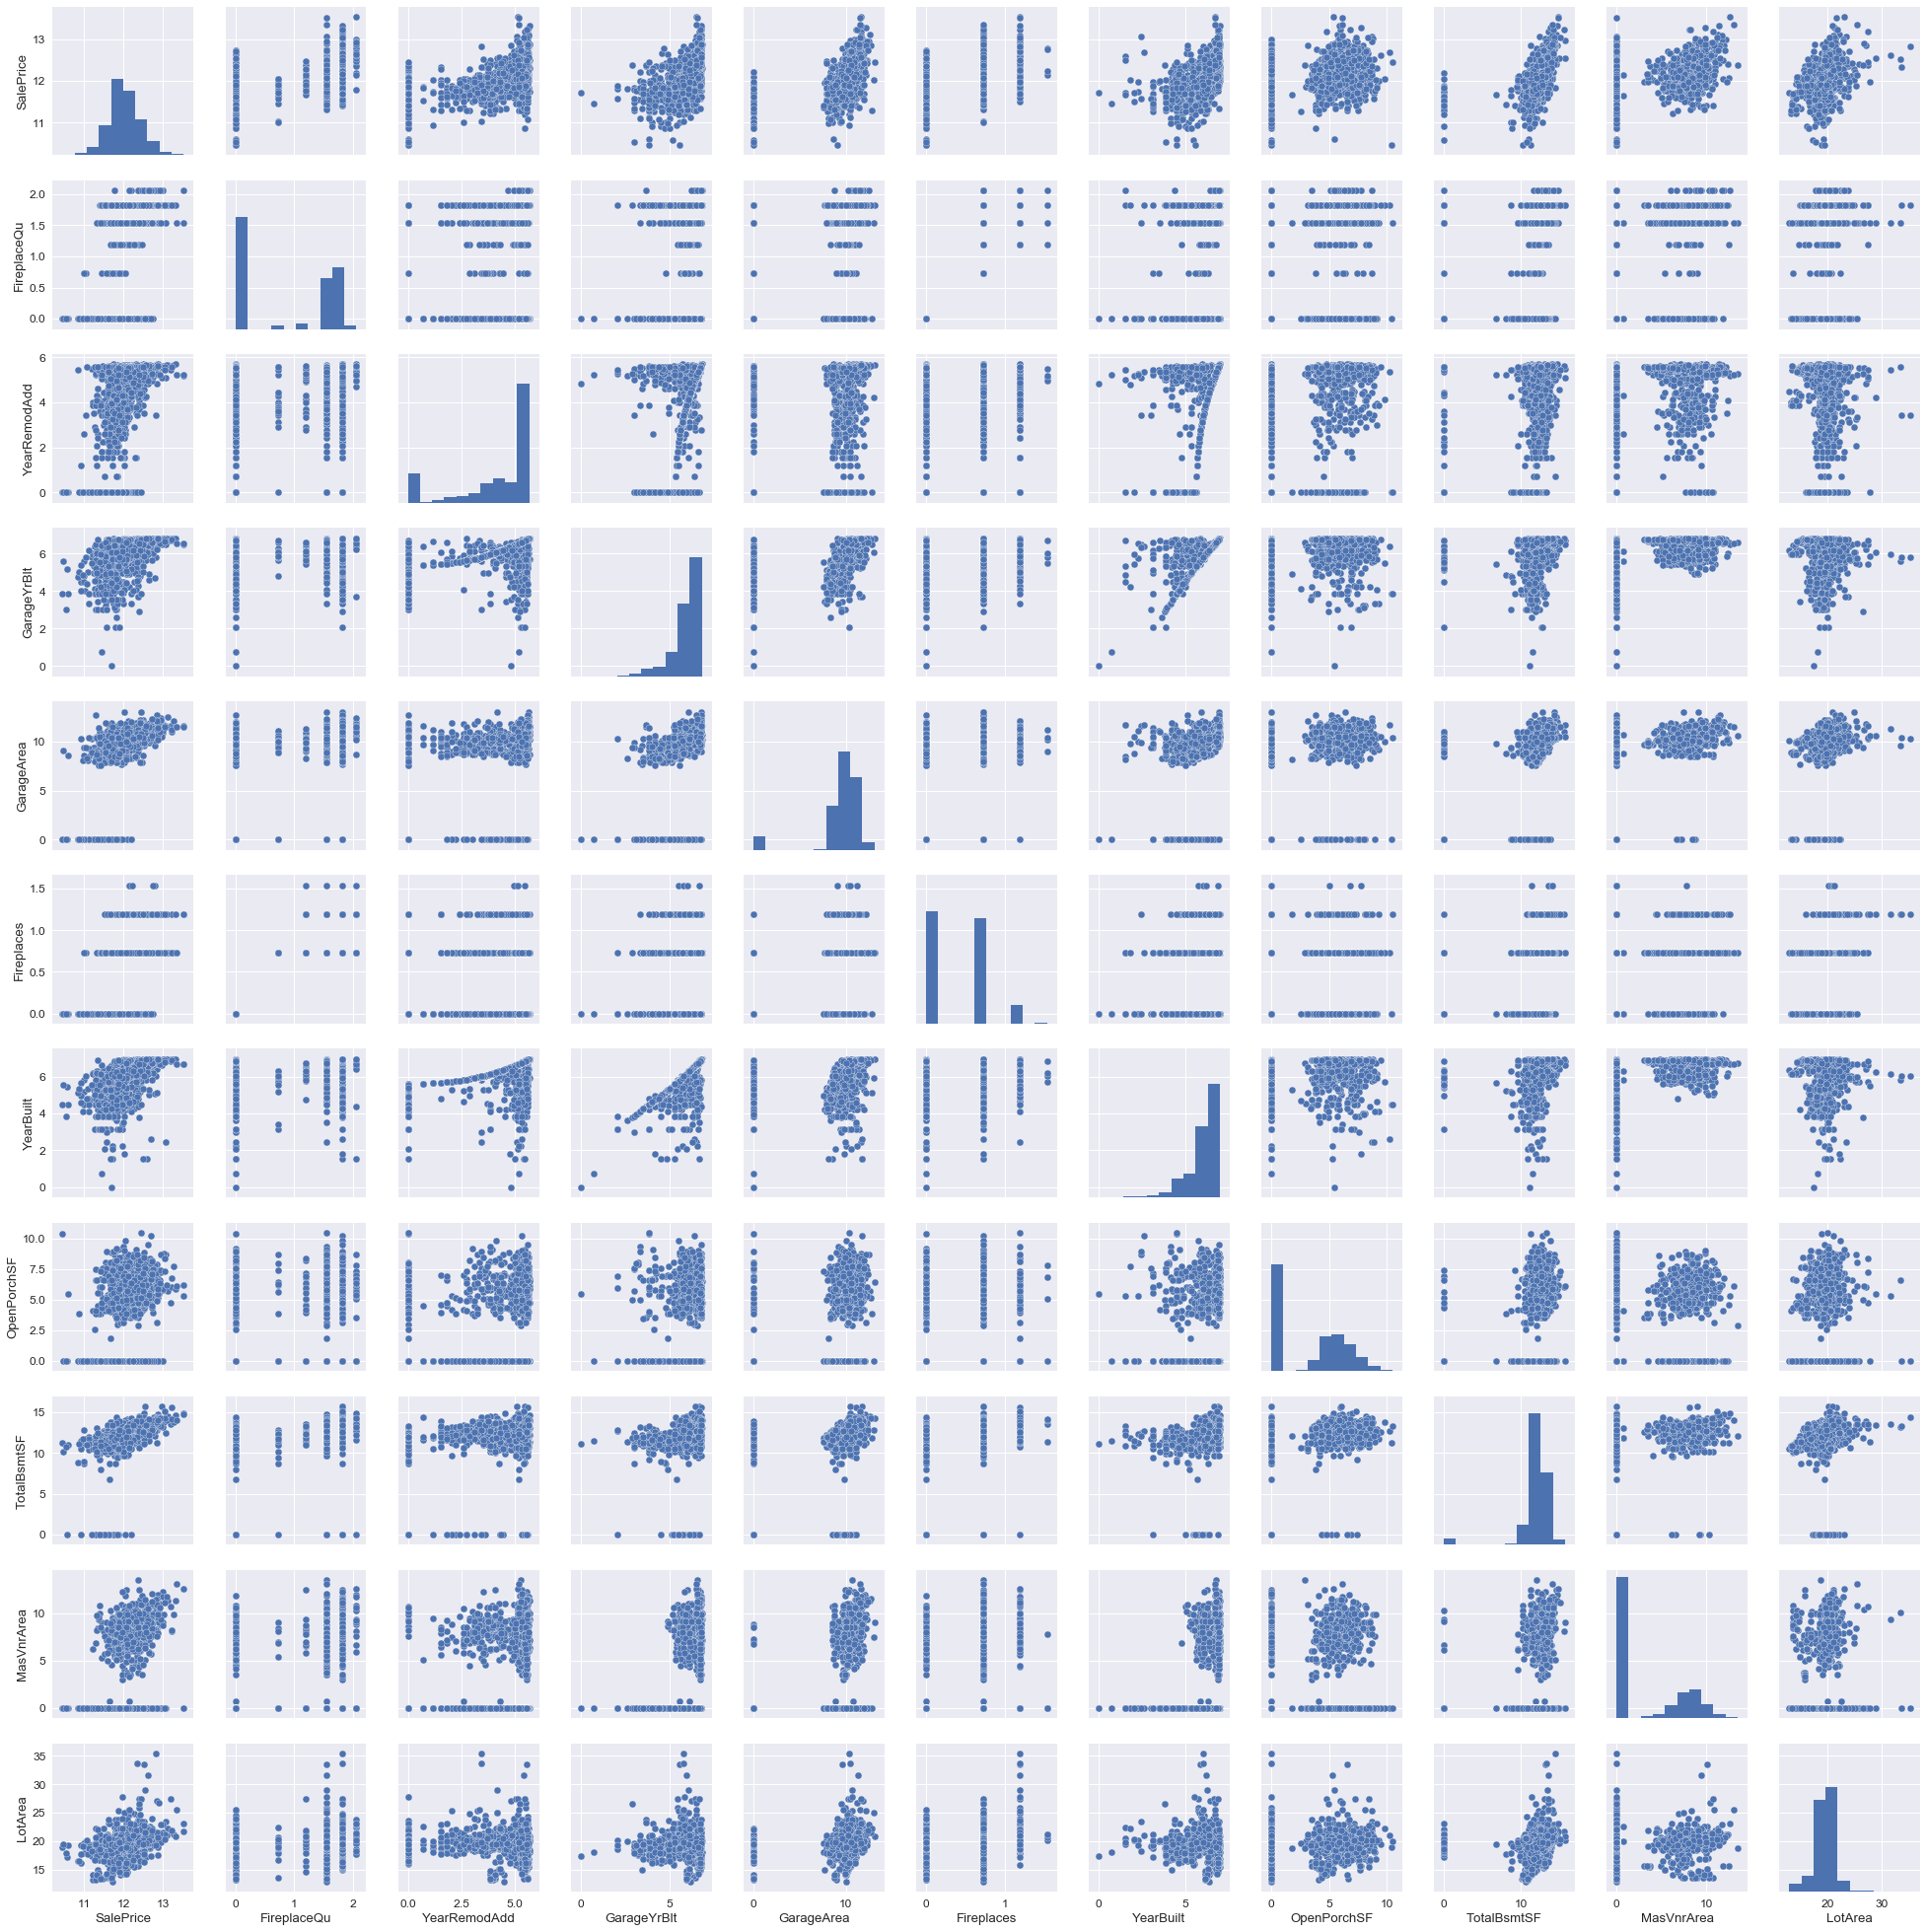

In [97]:
pairing=['SalePrice']
pairing = np.append(pairing,features[11:21])
sns.pairplot(new_train[pairing], size=2.5)

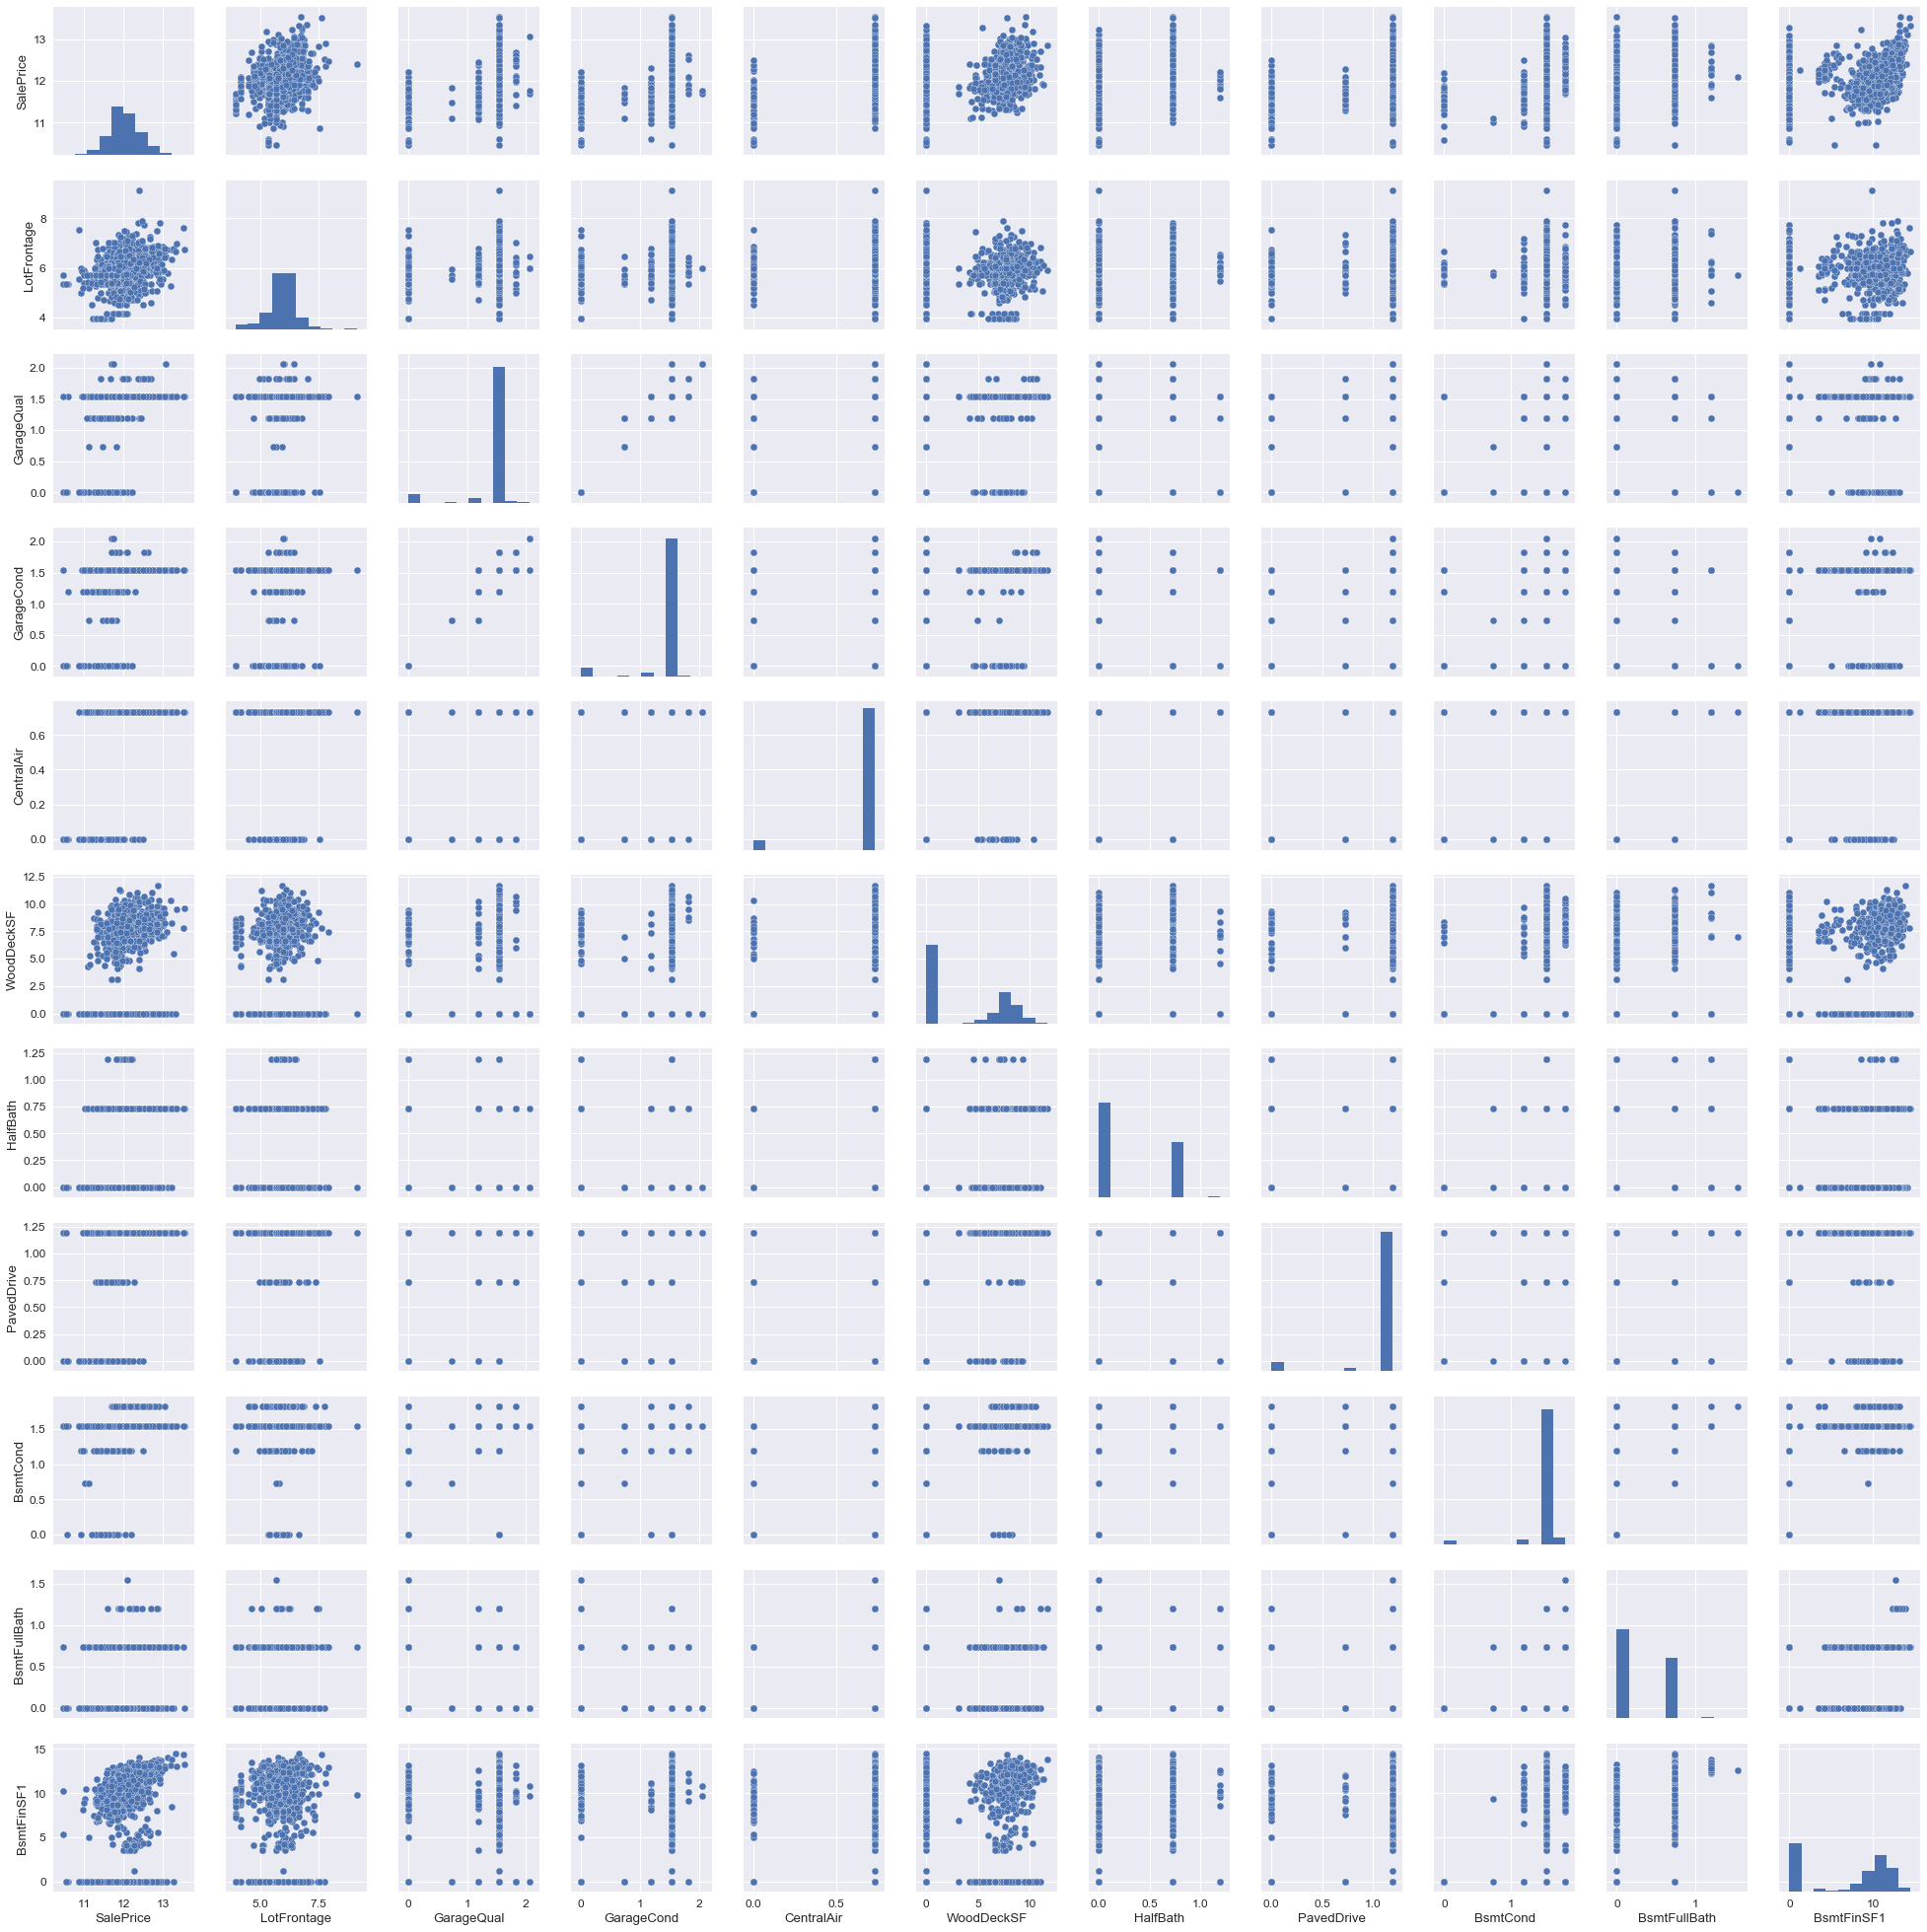

In [98]:
pairing=['SalePrice']
pairing = np.append(pairing,features[21:31])
sns.pairplot(new_train[pairing], size=2.5)

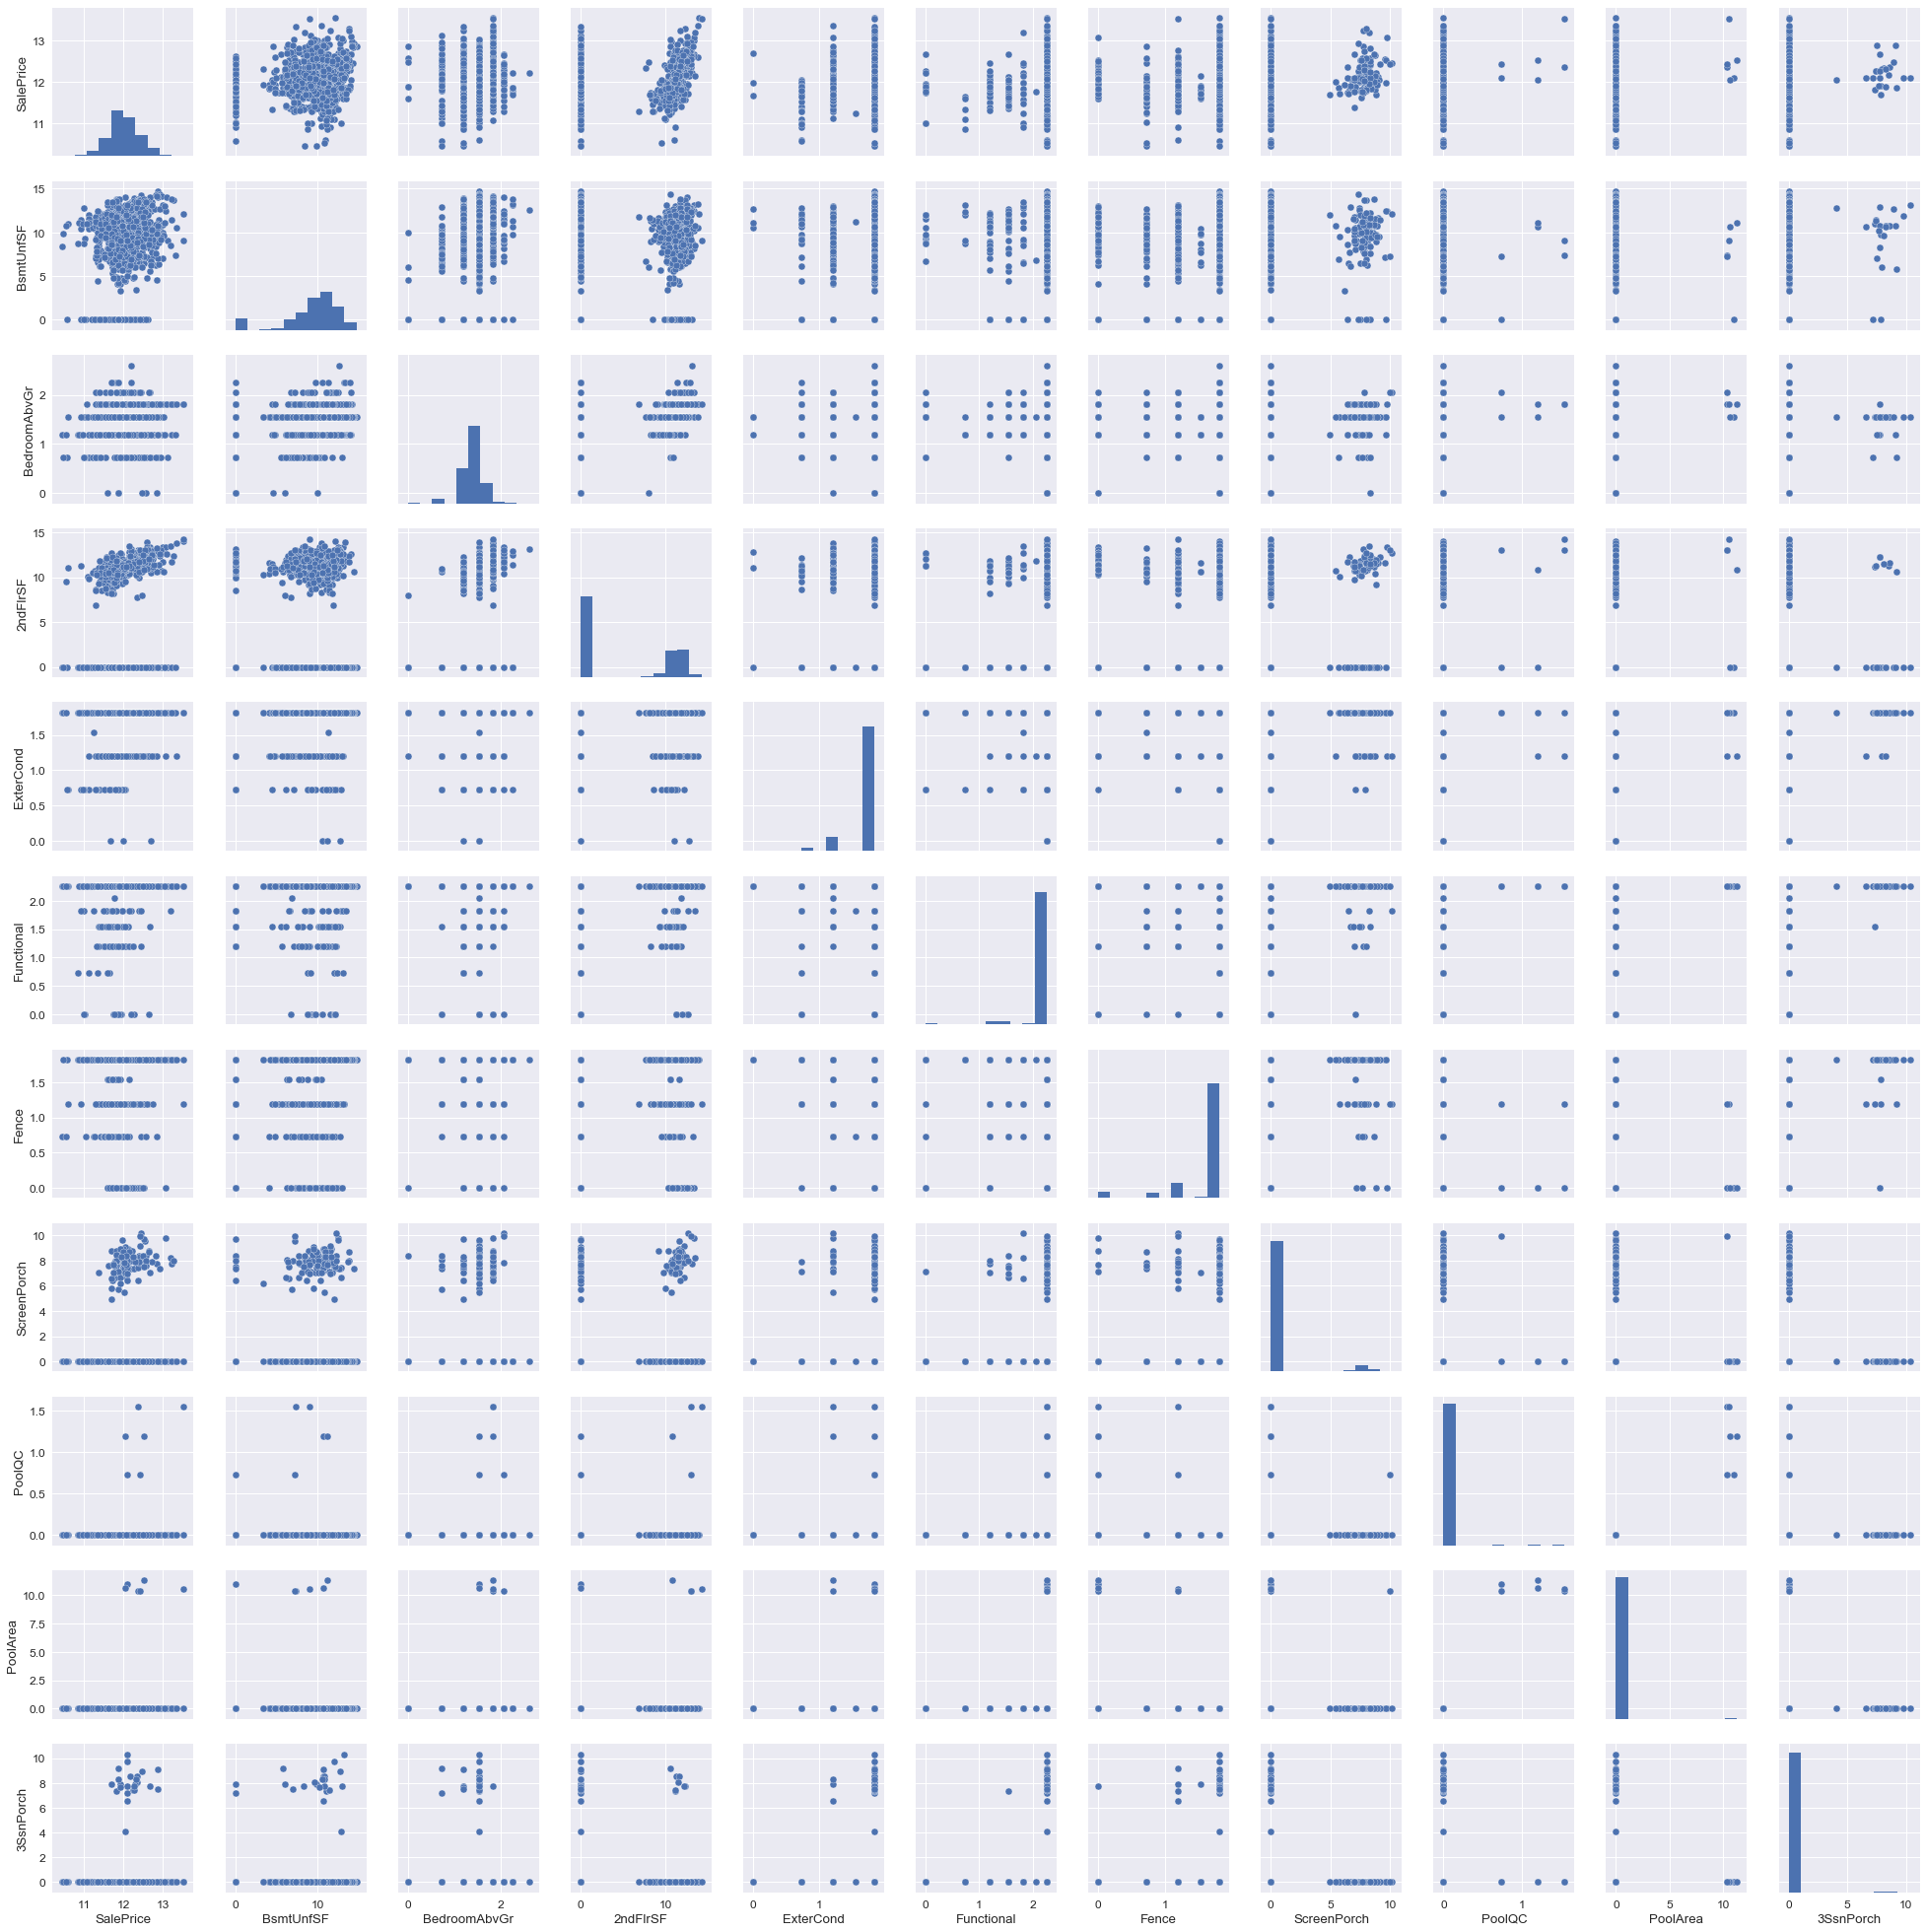

In [99]:
pairing=['SalePrice']
pairing = np.append(pairing,features[31:41])
sns.pairplot(new_train[pairing], size=2.5)

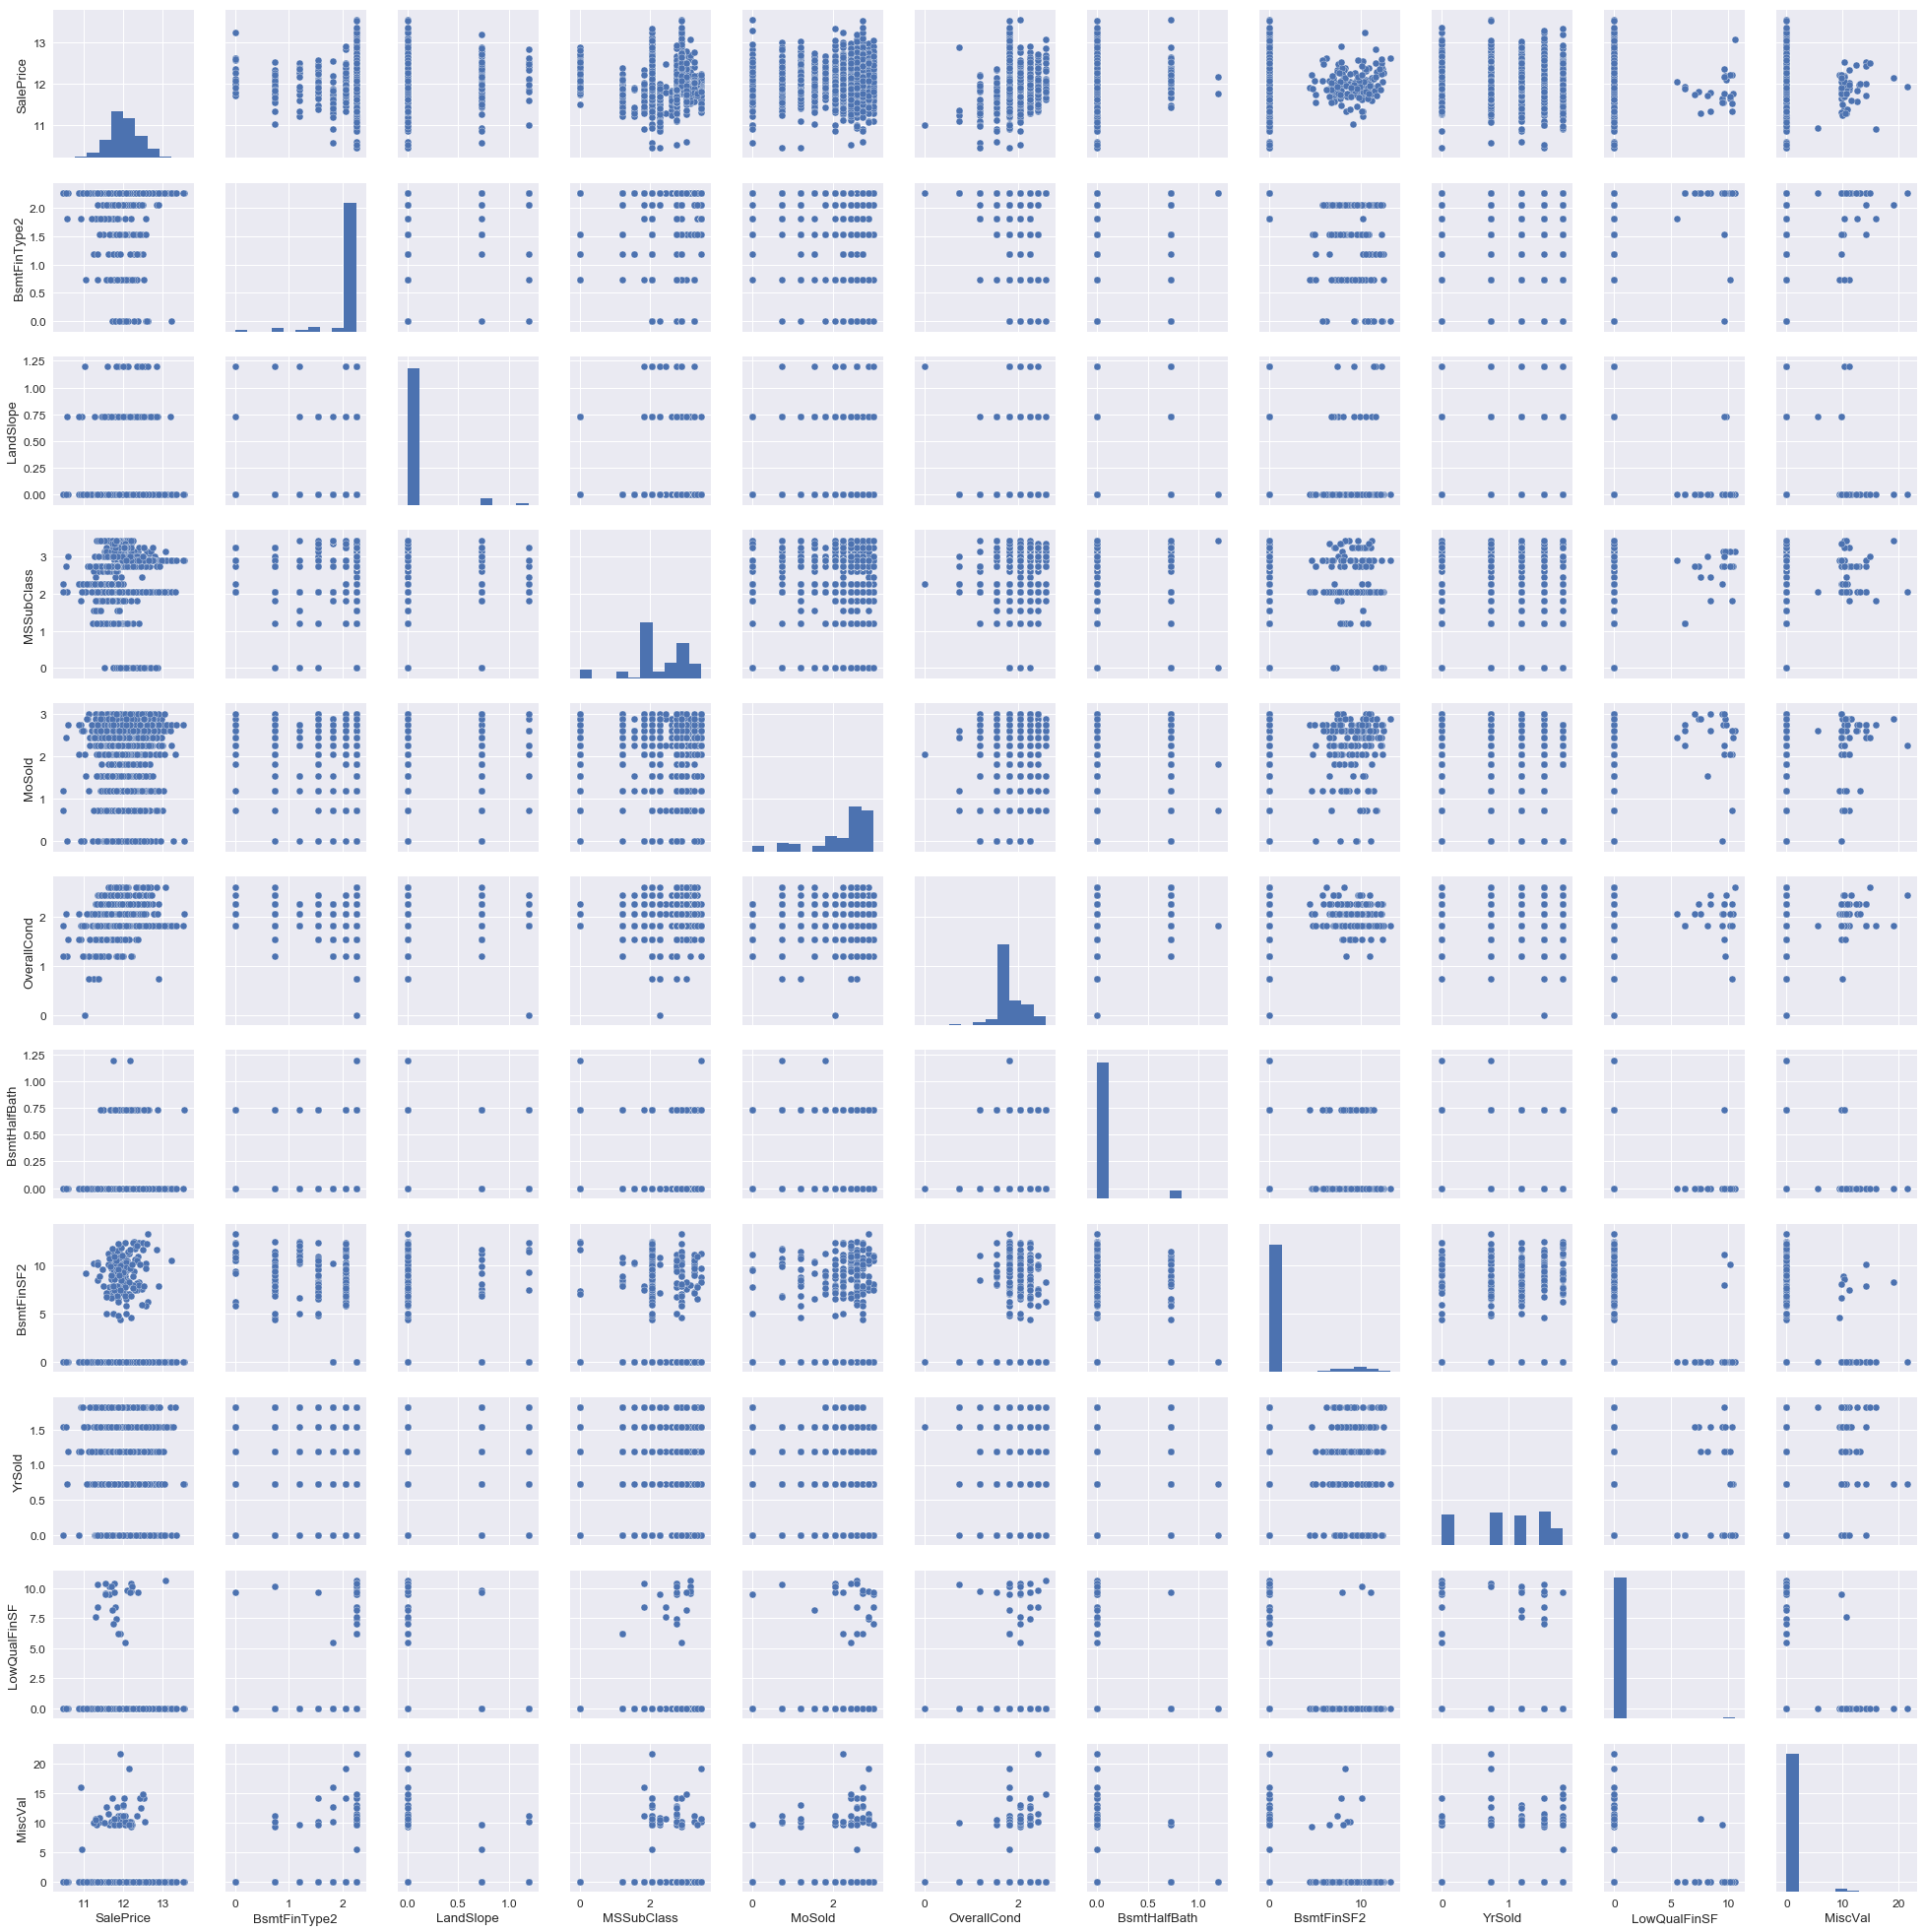

In [100]:
pairing=['SalePrice']
pairing = np.append(pairing,features[41:51])
sns.pairplot(new_train[pairing], size=2.5)

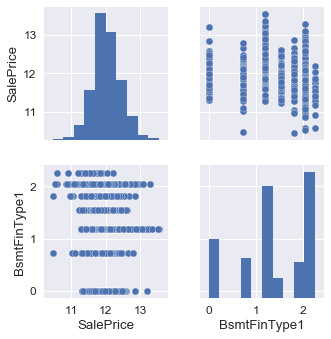

In [101]:
pairing=['SalePrice']
pairing = np.append(pairing,features[51:])
sns.pairplot(new_train[pairing], size=2.5)

saleprice와 나머지로 분리가능하다!

In [102]:
y_train = new_train.SalePrice.values
new_train.drop('SalePrice', axis=1, inplace=True)

In [103]:
ntrain = train.shape[0]
ntest = test.shape[0]

In [104]:
def detect_outliers(data, feature):
    
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    IQR = Q3 - Q1
        
    outlier_lenth = 1.5 * IQR
        
    outliers = data[(data[feature] < Q1 - outlier_lenth) | (data[feature] > Q3 + outlier_lenth)].index.tolist()

    return outliers

In [105]:
# GrLivArea_outliers = detect_outliers(train, "GrLivArea")
# print(GrLivArea_outliers)

In [106]:
# GarageCars_outliers = detect_outliers(train, "GarageArea")
# print(GarageCars_outliers)

In [107]:
# OverallQual_outliers = detect_outliers(train, "OverallQual")
# print(OverallQual_outliers)

## First OLS
- for detecting outliers & Selecting variables

In [108]:
train = all_data[:ntrain]
test = all_data[ntrain:]

train = sm.add_constant(train)
train.tail()

const   1stFlrSF   2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  \
1453    1.0  11.990298  11.124583        0.0  None      1.540963     1Fam   
1454    1.0  14.295205   0.000000        0.0  None      1.540963     1Fam   
1455    1.0  12.616840  12.528113        0.0  None      1.820334     1Fam   
1456    1.0  12.338074   0.000000        0.0  None      1.194318     1Fam   
1457    1.0  12.778382   0.000000        0.0  None      1.540963     1Fam   

      BsmtCond  BsmtExposure  BsmtFinSF1    ...      SaleType  ScreenPorch  \
1453  1.540963      1.540963    0.000000    ...            WD          0.0   
1454  1.540963      1.540963   11.473247    ...            WD          0.0   
1455  1.820334      1.540963    8.823108    ...            WD          0.0   
1456  1.540963      1.194318    5.321541    ...            WD          0.0   
1457  1.540963      1.540963   11.607976    ...            WD          0.0   

      Street  TotRmsAbvGrd  TotalBsmtSF  WoodDeckSF  YearBuilt  YearRemodAdd  \
1453    Pave      2.440268    11.990298    0.000000   6.770766      5.357203   
1454    Pave      2.440268    13.385607    9.384956   6.337529      4.882973   
1455    Pave      2.750250    12.528113    0.000000   5.357203      5.559490   
1456    Pave      2.055642    12.338074    9.499560   5.591427      5.210789   
1457    Pave      2.259674    12.778382   11.281862   6.021742      3.438110   

        YrSold    TotalSF  
1453  0.730463  15.019350  
1454  1.820334  16.118017  
1455  1.820334  16.000045  
1456  1.820334  14.418948  
1457  1.194318  14.907678  

[5 rows x 81 columns]

### 1. numerical

In [109]:
numerical_features = all_data.select_dtypes(exclude = ["object"]).columns
categorical_features = all_data.select_dtypes(include = ["object"]).columns

In [110]:
train_n = train[numerical_features]
#train_n = train_n.drop(['Id', 'SalePrice'], axis=1)
y_train_l = np.log1p(y_train)

In [111]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_n.values, i) for i in range(train_n.values.shape[1])]
vif["features"] = train_n.columns
vif

#높으면 빼도 되는 것

VIF Factor       features
0    4414.208168       1stFlrSF
1      42.269407       2ndFlrSF
2       1.065332      3SsnPorch
3      76.147178   BedroomAbvGr
4     313.966093       BsmtCond
5       7.802697   BsmtExposure
6      11.405929     BsmtFinSF1
7       3.555580     BsmtFinSF2
8      10.064673   BsmtFinType1
9      93.124477   BsmtFinType2
10      3.673902   BsmtFullBath
11      1.249983   BsmtHalfBath
12    107.021686       BsmtQual
13     28.691686      BsmtUnfSF
14     24.219745     CentralAir
15      1.598721  EnclosedPorch
16     56.222010      ExterCond
17     38.411046      ExterQual
18     18.430249          Fence
19     20.246207    FireplaceQu
20     19.188871     Fireplaces
21     46.807109       FullBath
22     67.095043     Functional
23    421.533170     GarageArea
24     84.821631     GarageCars
25    541.717450     GarageCond
26      5.933816   GarageFinish
27    563.036462     GarageQual
28    186.669999    GarageYrBlt
29  14039.568607      GrLivArea
30      3.843678       HalfBath
31      2.953571      HeatingQC
32     86.853994   KitchenAbvGr
33     26.123651    KitchenQual
34      1.322429      LandSlope
35    240.944173        LotArea
36    213.768182    LotFrontage
37      3.458195       LotShape
38      1.791780   LowQualFinSF
39     22.439237     MSSubClass
40      2.343600     MasVnrArea
41      1.122272        MiscVal
42     10.309831         MoSold
43      3.035350    OpenPorchSF
44    105.188184    OverallCond
45    275.061594    OverallQual
46     23.486698     PavedDrive
47     13.156553       PoolArea
48     13.243285         PoolQC
49   2845.524096      SalePrice
50      1.225982    ScreenPorch
51    327.428241   TotRmsAbvGrd
52   1053.147295    TotalBsmtSF
53      2.509906     WoodDeckSF
54    213.682864      YearBuilt
55     13.275598   YearRemodAdd
56      3.708468         YrSold
57  18317.001942        TotalSF

In [112]:
model1_1 = sm.OLS(y_train_l, train_n)
result1_1 = model1_1.fit()
print(result1_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.051e+05
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:25:57   Log-Likelihood:                 3442.1
No. Observations:                1458   AIC:                            -6768.
Df Residuals:                    1400   BIC:                            -6462.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
1stFlrSF         -0.0058      0.003     -1.779

### 2. categorical(dummies)

In [113]:
categorical_features = train[categorical_features]

In [114]:
#utilities none값에서 삭제 했음
categorical_features = ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']

train_c = pd.get_dummies(train[categorical_features])
train_c.tail()

MSSubClass  LotShape  LandSlope  ExterQual  ExterCond  BsmtQual  \
1453    2.885846  1.540963        0.0   0.730463   1.820334  1.540963   
1454    2.055642  1.540963        0.0   0.730463   1.820334  1.540963   
1455    3.011340  1.540963        0.0   1.540963   1.194318  1.194318   
1456    2.055642  1.540963        0.0   0.730463   1.820334  1.194318   
1457    2.055642  1.540963        0.0   1.194318   1.820334  1.194318   

      BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  \
1453  1.540963      1.540963      2.055642      2.259674   
1454  1.540963      1.540963      0.000000      2.055642   
1455  1.820334      1.540963      1.194318      2.259674   
1456  1.540963      1.194318      1.194318      2.055642   
1457  1.540963      1.540963      0.730463      1.540963   

              ...            SaleType_ConLw  SaleType_New  SaleType_Oth  \
1453          ...                         0             0             0   
1454          ...                         0             0             0   
1455          ...                         0             0             0   
1456          ...                         0             0             0   
1457          ...                         0             0             0   

      SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
1453            1                      0                      0   
1454            1                      0                      0   
1455            1                      0                      0   
1456            1                      0                      0   
1457            1                      0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
1453                     0                     0                     1   
1454                     0                     0                     1   
1455                     0                     0                     1   
1456                     0                     0                     1   
1457                     0                     0                     1   

      SaleCondition_Partial  
1453                      0  
1454                      0  
1455                      0  
1456                      0  
1457                      0  

[5 rows x 178 columns]

In [115]:
model1_2 = sm.OLS(y_train_l, train_c)
result1_2 = model1_2.fit()
print(result1_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     46.43
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:25:57   Log-Likelihood:                 4388.0
No. Observations:                1458   AIC:                            -8460.
Df Residuals:                    1300   BIC:                            -7625.
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass               -0.00

### 3. numerical + categorical(dummies)

In [116]:
train_all = pd.concat([train_n, train_c], axis=1)
train_all.tail()

1stFlrSF   2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  \
1453  11.990298  11.124583        0.0      1.540963  1.540963      1.540963   
1454  14.295205   0.000000        0.0      1.540963  1.540963      1.540963   
1455  12.616840  12.528113        0.0      1.820334  1.820334      1.540963   
1456  12.338074   0.000000        0.0      1.194318  1.540963      1.194318   
1457  12.778382   0.000000        0.0      1.540963  1.540963      1.540963   

      BsmtFinSF1  BsmtFinSF2  BsmtFinType1  BsmtFinType2  \
1453    0.000000    0.000000      2.055642      2.259674   
1454   11.473247    7.659675      0.000000      2.055642   
1455    8.823108    0.000000      1.194318      2.259674   
1456    5.321541   12.206046      1.194318      2.055642   
1457   11.607976    8.946561      0.730463      1.540963   

              ...            SaleType_ConLw  SaleType_New  SaleType_Oth  \
1453          ...                         0             0             0   
1454          ...                         0             0             0   
1455          ...                         0             0             0   
1456          ...                         0             0             0   
1457          ...                         0             0             0   

      SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
1453            1                      0                      0   
1454            1                      0                      0   
1455            1                      0                      0   
1456            1                      0                      0   
1457            1                      0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
1453                     0                     0                     1   
1454                     0                     0                     1   
1455                     0                     0                     1   
1456                     0                     0                     1   
1457                     0                     0                     1   

      SaleCondition_Partial  
1453                      0  
1454                      0  
1455                      0  
1456                      0  
1457                      0  

[5 rows x 236 columns]

In [117]:
model1_3 = sm.OLS(y_train_l, train_all)
result1_3 = model1_3.fit()
print(result1_3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.449e+04
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:25:57   Log-Likelihood:                 9017.5
No. Observations:                1458   AIC:                        -1.764e+04
Df Residuals:                    1262   BIC:                        -1.661e+04
Df Model:                         195                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
1stFlrSF                 -0.00

### 4. numerical(correlation top 15)

In [118]:
cor_numerical_cols = ['OverallQual', 'GrLivArea', 'GarageCars',
       'TotalBsmtSF', 'FullBath',  'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'Fireplaces',
       'BsmtFinSF1']

train_nc = train[cor_numerical_cols]
train_nc.tail()

OverallQual  GrLivArea  GarageCars  TotalBsmtSF  FullBath  YearBuilt  \
1453     2.259674  13.584606    1.194318    11.990298  1.194318   6.770766   
1454     2.259674  14.295205    1.194318    13.385607  1.194318   6.337529   
1455     2.440268  14.679454    0.730463    12.528113  1.194318   5.357203   
1456     2.055642  12.338074    0.730463    12.338074  0.730463   5.591427   
1457     2.055642  12.778382    0.730463    12.778382  0.730463   6.021742   

      YearRemodAdd  MasVnrArea  Fireplaces  BsmtFinSF1  
1453      5.357203    0.000000    0.730463    0.000000  
1454      4.882973    7.003881    1.194318   11.473247  
1455      5.559490    0.000000    1.194318    8.823108  
1456      5.210789    0.000000    0.000000    5.321541  
1457      3.438110    0.000000    0.000000   11.607976

In [119]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_nc.values, i) for i in range(train_nc.values.shape[1])]
vif["features"] = train_nc.columns
vif

VIF Factor      features
0  182.718756   OverallQual
1  148.319337     GrLivArea
2   15.278620    GarageCars
3   42.108728   TotalBsmtSF
4   28.224126      FullBath
5   61.731285     YearBuilt
6    9.408629  YearRemodAdd
7    2.035630    MasVnrArea
8    2.431466    Fireplaces
9    3.552654    BsmtFinSF1

In [120]:
model1_4 = sm.OLS(y_train_l, train_nc)
result1_4 = model1_4.fit()
print(result1_4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 7.585e+04
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:25:58   Log-Likelihood:                 1122.7
No. Observations:                1458   AIC:                            -2225.
Df Residuals:                    1448   BIC:                            -2173.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
OverallQual      0.1004      0.018      5.731   

### 5. numerical + categorical(correlation top 15,5)

In [121]:
cor_categorical_cols = [ 'ExterQual', 'KitchenQual','BsmtQual']

train_cc = train[cor_categorical_cols]
train_cc.tail()

train_all_c = pd.concat([train_nc, train_cc], axis=1)
train_all_c.tail()

OverallQual  GrLivArea  GarageCars  TotalBsmtSF  FullBath  YearBuilt  \
1453     2.259674  13.584606    1.194318    11.990298  1.194318   6.770766   
1454     2.259674  14.295205    1.194318    13.385607  1.194318   6.337529   
1455     2.440268  14.679454    0.730463    12.528113  1.194318   5.357203   
1456     2.055642  12.338074    0.730463    12.338074  0.730463   5.591427   
1457     2.055642  12.778382    0.730463    12.778382  0.730463   6.021742   

      YearRemodAdd  MasVnrArea  Fireplaces  BsmtFinSF1  ExterQual  \
1453      5.357203    0.000000    0.730463    0.000000   0.730463   
1454      4.882973    7.003881    1.194318   11.473247   0.730463   
1455      5.559490    0.000000    1.194318    8.823108   1.540963   
1456      5.210789    0.000000    0.000000    5.321541   0.730463   
1457      3.438110    0.000000    0.000000   11.607976   1.194318   

      KitchenQual  BsmtQual  
1453     0.730463  1.540963  
1454     0.730463  1.540963  
1455     1.194318  1.194318  
1456     1.194318  1.194318  
1457     0.730463  1.194318

In [122]:
train_all_c = sm.add_constant(train_all_c)
train_all_c = pd.get_dummies(train_all_c)

train_all_c.tail()

const  OverallQual  GrLivArea  GarageCars  TotalBsmtSF  FullBath  \
1453    1.0     2.259674  13.584606    1.194318    11.990298  1.194318   
1454    1.0     2.259674  14.295205    1.194318    13.385607  1.194318   
1455    1.0     2.440268  14.679454    0.730463    12.528113  1.194318   
1456    1.0     2.055642  12.338074    0.730463    12.338074  0.730463   
1457    1.0     2.055642  12.778382    0.730463    12.778382  0.730463   

      YearBuilt  YearRemodAdd  MasVnrArea  Fireplaces  BsmtFinSF1  ExterQual  \
1453   6.770766      5.357203    0.000000    0.730463    0.000000   0.730463   
1454   6.337529      4.882973    7.003881    1.194318   11.473247   0.730463   
1455   5.357203      5.559490    0.000000    1.194318    8.823108   1.540963   
1456   5.591427      5.210789    0.000000    0.000000    5.321541   0.730463   
1457   6.021742      3.438110    0.000000    0.000000   11.607976   1.194318   

      KitchenQual  BsmtQual  
1453     0.730463  1.540963  
1454     0.730463  1.540963  
1455     1.194318  1.194318  
1456     1.194318  1.194318  
1457     0.730463  1.194318

In [123]:
model1_5 = sm.OLS(y_train_l, train_all_c)
result1_5 = model1_5.fit()
print(result1_5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     701.1
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:25:58   Log-Likelihood:                 4461.9
No. Observations:                1458   AIC:                            -8896.
Df Residuals:                    1444   BIC:                            -8822.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2733      0.006    360.891   

In [124]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_all_c.values, i) for i in range(train_all_c.values.shape[1])]
vif["features"] = train_all_c.columns
vif

VIF Factor      features
0   445.348202         const
1     3.236900   OverallQual
2     2.663998     GrLivArea
3     1.746737    GarageCars
4     2.792010   TotalBsmtSF
5     2.154778      FullBath
6     2.181435     YearBuilt
7     1.742736  YearRemodAdd
8     1.350760    MasVnrArea
9     1.405722    Fireplaces
10    1.233580    BsmtFinSF1
11    2.630661     ExterQual
12    2.338293   KitchenQual
13    3.817119      BsmtQual

In [125]:
model_cat = sm.OLS.from_formula("SalePrice ~ (Neighborhood)", data=train)
sm.stats.anova_lm(model_cat.fit())

df      sum_sq  mean_sq          F         PR(>F)
Neighborhood    24.0  133.120314  5.54668  79.751025  1.634888e-243
Residual      1433.0   99.665078  0.06955        NaN            NaN

In [126]:
model_cat = sm.OLS.from_formula("SalePrice ~ C(ExterQual)", data=train)
sm.stats.anova_lm(model_cat.fit())

df      sum_sq    mean_sq           F         PR(>F)
C(ExterQual)     3.0  108.392488  36.130829  422.324938  2.866856e-197
Residual      1454.0  124.392904   0.085552         NaN            NaN

In [127]:
model_cat = sm.OLS.from_formula("SalePrice ~ C(KitchenQual)", data=train)
sm.stats.anova_lm(model_cat.fit())

df      sum_sq    mean_sq           F         PR(>F)
C(KitchenQual)     3.0  104.891285  34.963762  397.495324  1.637677e-188
Residual        1454.0  127.894107   0.087960         NaN            NaN

In [128]:
model_cat = sm.OLS.from_formula("SalePrice ~ C(BsmtQual)", data=train)
sm.stats.anova_lm(model_cat.fit())

df      sum_sq    mean_sq           F         PR(>F)
C(BsmtQual)     4.0  105.990105  26.497526  303.646186  6.791010e-190
Residual     1453.0  126.795287   0.087264         NaN            NaN

In [129]:
# model_cat = sm.OLS.from_formula("SalePrice ~ C(PoolQC)", data=train)
# sm.stats.anova_lm(model_cat.fit())

#### 성능 비교

In [130]:
# adj r^2
print(result1_1.rsquared_adj)
print(result1_2.rsquared_adj)
print(result1_3.rsquared_adj)
print(result1_4.rsquared_adj)
print(result1_5.rsquared_adj)

0.9999176094841569
0.8303733211138749
0.9996949305089592
0.9980813939010353
0.861997808460725


In [131]:
#AIC
print(result1_1.aic)
print(result1_2.aic)
print(result1_3.aic)
print(result1_4.aic)
print(result1_5.aic)

-6768.186366723727
-8460.071849191545
-17643.07490398911
-2225.4209481655143
-8895.734697863381


In [132]:
#BIC
print(result1_1.bic)
print(result1_2.bic)
print(result1_3.bic)
print(result1_4.bic)
print(result1_5.bic)

-6461.666753794748
-7625.070145005706
-16607.25000512566
-2172.5727390398283
-8821.74720508742


- adj r^2 : 모델 1, 4 거의 비슷
- AIC : 모델 1, 5 거의 비슷
- BIC : 모델 1, 5 거의 비슷

#### partial regression plot & CCPR

In [133]:
# fig = plt.figure(figsize=(8,30))
# sm.graphics.plot_partregress_grid(result1_1, fig=fig)
# fig.suptitle("")
# plt.show

In [134]:
# fig = plt.figure(figsize=(15,40))
# sm.graphics.plot_ccpr_grid(result1_1, fig=fig)
# fig.suptitle("")
# plt.show

## Outliers

In [135]:
influence = result1_1.get_influence()
# hat = influence.hat_matrix_diag

# plt.figure(figsize=(15,6))
# plt.stem(hat)
# plt.show()

In [136]:
# hat.sum()

In [137]:
# plt.figure(figsize=(15, 6))
# plt.stem(result1_1.resid_pearson)
# plt.show()

In [138]:
# g = sm.graphics.plot_leverage_resid2(result1_1)
# g.set_size_inches(15,5)
# plt.show()

In [139]:
o_train = train[result1_1.resid_pearson > 2]
print(len(o_train))
idx_r = np.where(result1_1.resid_pearson > 2)[0]
print(idx_r)

40
[  30   93  197  308  398  410  431  439  462  495  530  559  587  627
  631  661  665  675  709  713  771  811  873  880  915  967  990 1062
 1067 1223 1278 1322 1323 1347 1360 1376 1378 1381 1430 1451]


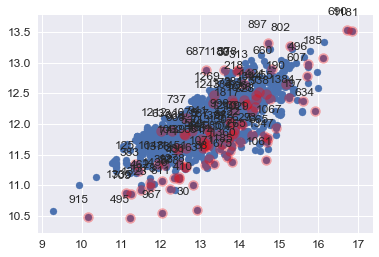

98 [   7   30   48   53   74   78   88   93  125  172  175  181  185  190
  197  218  313  328  335  378  383  384  386  398  410  431  439  441
  462  495  496  530  559  587  606  607  627  631  633  634  660  661
  665  668  675  687  690  709  713  737  771  802  811  842  873  897
  915  938  941  967  969  985  990 1029 1047 1048 1058 1061 1062 1067
 1071 1079 1180 1181 1185 1210 1212 1243 1265 1269 1278 1302 1322 1323
 1335 1344 1347 1360 1376 1378 1381 1384 1391 1397 1421 1430 1451 1455]


In [140]:
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(y_train_l) - len(train_n.columns) - 1)
idx_c = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(train['GrLivArea'], y_train)
plt.scatter(train['GrLivArea'][idx_c], y_train[idx_c], s=100, c="r", alpha=0.3)
utils.annotate_axes(range(len(idx_c)), idx_c, 
                    list(zip(train['GrLivArea'][idx_c], y_train[idx_c])), [(-20, 15)] * len(idx_c), size="small", ax=ax)
plt.show()

print(len(idx_c),idx_c)

In [141]:
resid_outliers = idx_r.tolist()
cooks_outliers = idx_c.tolist()
print("resid_outliers:", len(resid_outliers), resid_outliers)
print("\t")
print("cooks_outliers:", len(cooks_outliers), cooks_outliers)
print("\t")
# print("(IQR)GrLivArea_outliers:", len(GrLivArea_outliers), GrLivArea_outliers)
# print("\t")
# print("(IQR)OverallQual_outliers", len(OverallQual_outliers), OverallQual_outliers)
# print("\t")
# print("(IQR)GarageCars_outliers:", len(GarageCars_outliers), GarageCars_outliers)

#제거하길 추천한 outliers(data description)
recommended_outliers = [523, 898, 1298]

resid_outliers: 40 [30, 93, 197, 308, 398, 410, 431, 439, 462, 495, 530, 559, 587, 627, 631, 661, 665, 675, 709, 713, 771, 811, 873, 880, 915, 967, 990, 1062, 1067, 1223, 1278, 1322, 1323, 1347, 1360, 1376, 1378, 1381, 1430, 1451]
	
cooks_outliers: 98 [7, 30, 48, 53, 74, 78, 88, 93, 125, 172, 175, 181, 185, 190, 197, 218, 313, 328, 335, 378, 383, 384, 386, 398, 410, 431, 439, 441, 462, 495, 496, 530, 559, 587, 606, 607, 627, 631, 633, 634, 660, 661, 665, 668, 675, 687, 690, 709, 713, 737, 771, 802, 811, 842, 873, 897, 915, 938, 941, 967, 969, 985, 990, 1029, 1047, 1048, 1058, 1061, 1062, 1067, 1071, 1079, 1180, 1181, 1185, 1210, 1212, 1243, 1265, 1269, 1278, 1302, 1322, 1323, 1335, 1344, 1347, 1360, 1376, 1378, 1381, 1384, 1391, 1397, 1421, 1430, 1451, 1455]
	


In [142]:
IQR = list(set(GrLivArea_outliers) | set(OverallQual_outliers) | set(GarageCars_outliers))
print(IQR)

NameError: name 'GrLivArea_outliers' is not defined

In [ ]:
resid_cooks = list(set(resid_outliers) | set(cooks_outliers))
print(resid_cooks)

In [ ]:
IQR2 = list(set(GrLivArea_outliers) & set(GarageCars_outliers))
print(IQR2)

In [ ]:
resid_cooks_IQR = list(set(resid_cooks) | set(IQR))
print(resid_cooks_IQR)

## Select Variables

In [ ]:
idx_t = np.where(result1_1.pvalues < 0.05)[0]
print(len(idx_t), idx_t)
tvalues = idx_t.tolist()

In [ ]:
x_train_cols = train_n.columns.tolist()
print(len(x_train_cols))

select = []

for i in tvalues:
    select.append(x_train_cols[i])

print(len(select), select)

In [ ]:
idx_t2 = np.where(result1_3.pvalues < 0.005)[0]
print(len(idx_t2), idx_t2)
tvalues2 = idx_t2.tolist()

x_train_cols2 = train_all.columns.tolist()
print(len(x_train_cols2))

select_c = []

for i in tvalues2:
    select_c.append(x_train_cols2[i])

print(len(select_c), select_c)

select_c = ['MSZoning', 'Neighborhood', 'Condition2', 'RoofMatl', 'Functional']

In [ ]:
x_train_new = train_n[select]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train_new.values, i) for i in range(x_train_new.values.shape[1])]
vif["features"] ="'" + x_train_new.columns + "'"
vif.sort_values(by="VIF Factor", ascending=True)

- Yearsold, YearRemodAdd, TotRmsAbvGrd, OverallQual 제외

- ** OverrallCond, 1stFlrSF, KitchenAbvGr, PoolArea, Screenporch(from_formula 사용시)

In [ ]:
select = ['BsmtCond','BsmtQual','ExterQual', 'LotArea', 'OverallCond',  'KitchenAbvGr', 'PoolArea']
print(len(select), select)

x_train_new = x_train_new[select]

- 참고 : 상관계수와 coef?

In [ ]:
print(len(cor_numerical_cols),cor_numerical_cols)
print("\t")

cols_common = set(select) & set(cor_numerical_cols)
cols_sum = set(select) | set(cor_numerical_cols)

print(len(cols_common), cols_common)
print("\t")
print(len(cols_sum), cols_sum)

In [ ]:
select = ['YearRemodAdd', 'BsmtFinSF1', 'BsmtQual', 'LotArea', 'GarageCars', 'OverallQual', 'PoolArea', 'KitchenAbvGr', 'YearBuilt', 'Fireplaces', 'MasVnrArea', 'GrLivArea', 'BsmtCond', 'TotalBsmtSF', 'FullBath', 'ExterQual', 'OverallCond']
len(select)

In [ ]:
select_VIF = ['MasVnrArea', 'EnclosedPorch', 'BsmtFinSF1', 'GarageCars', 'BsmtFullBath', 'Fireplaces', 'TotalBsmtSF', 'ScreenPorch', 'WoodDeckSF', 'LotArea', 'YearBuilt', 'GrLivArea', 'KitchenAbvGr', 'FullBath', 'OverallQual', 'OverallCond']

In [ ]:
x_train_new = train_n[select_VIF]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train_new.values, i) for i in range(x_train_new.values.shape[1])]
vif["features"] = x_train_new.columns
vif.sort_values(by="VIF Factor", ascending=True)

## Second OLS

In [ ]:
train_cc = train[cor_categorical_cols]

In [ ]:
#추가 작업
# train_cc = train_cc.drop(['PoolQC'], axis=1)

#train_cc = train_cc.drop(resid_cooks)
train_n = train_n[select_VIF]
#train_n = train_n.drop(resid_cooks)
#추가 작업-변수 변환 
train_n = np.log1p(train_n)
x_train_new = train_n
x_train_new = pd.concat([train_n, train_cc], axis=1)
#add constatns
# x_train_new = sm.add_constant(x_train_new)

y_train_new = y_train
y_train_new = np.log1p(y_train_new)

# #from_formula 사용 위해
train_new = pd.concat([y_train_new, x_train_new], axis=1)
train_new.tail()

In [ ]:
select_scale = []

for num in select_VIF:
    x = "scale(" + num + ")"
    select_scale.append(x)

print(select_scale)

formula = " + ".join(select_scale)
formula

In [ ]:
train_cc.columns

In [ ]:
train_new.tail()

In [ ]:
# train_new = train_new.drop(['1stFlrSF'], axis=1)
train_new.tail()

In [ ]:
# x_train_new = pd.get_dummies(x_train_new)
# x_train_new.tail()

In [ ]:
categorical_features

In [ ]:
model2_1 = sm.OLS.from_formula("SalePrice ~ scale(MasVnrArea) + scale(EnclosedPorch) + scale(BsmtFinSF1) + scale(GarageCars) + scale(BsmtFullBath) + scale(Fireplaces) + scale(TotalBsmtSF) + scale(ScreenPorch) + scale(WoodDeckSF) + scale(LotArea) + scale(YearBuilt) + scale(GrLivArea) + scale(KitchenAbvGr) + scale(FullBath) + scale(OverallQual) + scale(OverallCond)", data=train_new)
result2_1 = model2_1.fit()
print(result2_1.summary())

- ANOVA

In [ ]:
# #모형비교

# model_full = sm.OLS.from_formula("SalePrice ~ scale(EnclosedPorch) + scale(BsmtFinSF1) + scale(OverallCond) + scale(GarageCars) + scale(BsmtFullBath) + scale(MasVnrArea) + scale(Fireplaces) + scale(TotalBsmtSF) + scale(ScreenPorch) + scale(WoodDeckSF) + scale(LotArea) + scale(YearBuilt) + scale(GrLivArea) + scale(KitchenAbvGr) + scale(FullBath) + scale(OverallQual) + C(Neighborhood) + C(ExterQual) + C(KitchenQual) + C(BsmtQual)", data=train_new)
# model_reduced = sm.OLS.from_formula("SalePrice ~ scale(EnclosedPorch) + scale(BsmtFinSF1) + scale(OverallCond) + scale(GarageCars) + scale(BsmtFullBath) + scale(MasVnrArea) + scale(Fireplaces) + scale(TotalBsmtSF) + scale(ScreenPorch) + scale(WoodDeckSF) + scale(LotArea) + scale(YearBuilt) + scale(GrLivArea) + scale(KitchenAbvGr) + scale(FullBath) + scale(OverallQual) + C(Neighborhood) + C(ExterQual) + C(KitchenQual) + C(BsmtQual)", data=train_new)

# sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

In [ ]:
#변수비교
sm.stats.anova_lm(result2_1, typ=2)

In [ ]:
# result2_2 = model2_1.fit_regularized(alpha=0.01, L1_wt=1)
# print(result2_2.params)

- RMSE

In [ ]:
train_new2 = train_new.drop(['SalePrice'], axis=1)

y_train_new2 = result2_1.predict(train_new2)
y_train_new2 = np.exp(y_train_new2)
y_train_new2 = np.array(y_train_new2)
print(y_train_new2)

In [ ]:
y_train_new = np.array(y_train_new)
y_train_new = np.exp(y_train_new)
print(y_train_new)

In [ ]:
sm.tools.eval_measures.rmse(y_train_new, y_train_new2, axis=0)

- 잔차 정규성

In [ ]:
test_norm = sms.omni_normtest(result2_1.resid)
for xi in zip(['Chi^2', 'P-value'], test_norm):
    print("%-12s: %6.3f" % xi)

In [ ]:
sp.stats.probplot(result2_1.resid, plot=plt)
plt.show()

In [ ]:
# select_new = ['EnclosedPorch', '1stFlrSF', 'BsmtFinSF1', 'GarageCars', 'YearRemodAdd', 'BsmtFullBath', 'MasVnrArea', 'Fireplaces', 'TotalBsmtSF', 'PoolArea', 'OverallCond', 'ScreenPorch', 'WoodDeckSF', 'LotArea', 'YearBuilt', 'GarageArea', 'GrLivArea', 'KitchenAbvGr', 'TotRmsAbvGrd', 'FullBath', 'GarageYrBlt', 'OverallQual'] 
select_new2 = ['Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual']

In [ ]:
test_new = test[select_VIF]
test_new = np.log1p(test_new)

# test_new = test_new.drop(['1stFlrSF'], axis=1)

test_new2 = test[select_new2]

test_new = pd.concat([test_new, test_new2], axis=1)
test_new.tail()
# test_new = pd.get_dummies(test_new)

# test_new = sm.add_constant(test_new)

In [ ]:
x = x_train_new.columns
y = test_new.columns

print(set(y) - set(x))

In [ ]:
y_new = result2_1.predict(test_new)
y_new = np.exp(y_new)
y_new = np.array(y_new)
print(y_new)

In [ ]:
submission = pd.read_csv("sample_submission.csv")

submission["SalePrice"] = y_new

print(submission.shape)
submission.head()

In [ ]:
submission.to_csv("24_submission.csv", index=False)

In [ ]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

modeling

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [ ]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [ ]:
grid(Lasso()).grid_get(test_new,y_new,{'alpha': [0.01,0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})


In [ ]:
grid(ElasticNet()).grid_get(test_new,y_new,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,1],'max_iter':[10000]})